# Интеграция с тинькофф

## Импорты

In [1]:
import tinvest as ti
import ta
import asyncio
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
from pytz import timezone
import pandas_datareader as pdr
import datetime, time
# import mpl_finance as mpf
# import mplfinance as mpf
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, f1_score, accuracy_score

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
# from ipynb.strategy_pipeline_ls import deal_now
# %run ST_NEW.ipynb

In [3]:
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, median
import itertools
from google.protobuf.timestamp_pb2 import Timestamp
from tqdm import tqdm
import itertools
import time
import random

In [4]:
#  Настройка ноутбука 
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

## Функции расчета метрик

In [5]:
def IND(data, window):
    """ Функция добавления ATR """
    data['ATR'] = ta.volatility.AverageTrueRange(high=data['High'], low=data['Low'], 
                                                 close=data['Close'], 
                                                 window=window, fillna=False).average_true_range()
    
    return data

In [6]:
def N_add(data, add_corr_N):
    """ Функция добавления N и изменения типа Date. N рассчитывается как среднее за 2 предыдущих дня """
    data.loc[20, 'N'] = data.loc[0:20, 'ATR'].mean() # первое значение N равно среднему
    for i in range(21, len(data), 1):
        # data.loc[i-5:i, 'N'].mean() - сглаживаю за неделю
        data.loc[i, 'N'] = round((19 * data.loc[i-2:i-1, 'N'].mean()  + data.loc[i, 'ATR'] )/20, 4)  # Все последующие значения рассчитываются по предыдущим N
    
#     data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d, %H:%M:%S") # При записи в файл строку включать!
    
    return data

In [7]:
def ind_min_max_difference(data, mmd_period):
    """ Функция рассчитывает разницу между максимальным и минимальным значением за определенный период"""
    for i in range(mmd_period, len(data)+1, 1):
        data.loc[i, 'MMD'] = data.loc[i-mmd_period : i-1, 'High'].max() - data.loc[i-mmd_period : i-1, 'Low'].min()
    return data

In [8]:
def normalized_volume_osc(data):
    """Функция рассчитывает значение нормализованного осцилятора объема. 
        10-дневная сумма [(закрытие - открытие) / (максимум - минимум) * объем] / 10-дневная сумма объема"""
    for i in range(10, len(data), 1):
        days_list = []
        for j in range(10, 0, -1):
            close = data.loc[j, 'Close']
            open_q = data.loc[j, 'Open']
            high = data.loc[j, 'High']
            low = data.loc[j, 'Low']
            volume = data.loc[j, 'Volume']
            summ = (close - open_q) / (high - low) * volume
            days_list.append(summ)
        data.loc[i, 'NVO'] = sum(days_list)
    return data  

def arr_normalized_volume_osc(stocks_dict_full_csv):
    """Функция рассчитывает значение нормализованного осцилятора объема. 
        10-дневная сумма [(закрытие - открытие) / (максимум - минимум) * объем] / 10-дневная сумма объема"""
    arr_stocks_dict_full_csv = arr_quotes_from_csv(stocks_dict_full_csv)
    columns = ['Open', 'Close', 'High', 'Low', 'Date','Volume', 'ATR', 'N', 'NVO']
    for key in tqdm(arr_stocks_dict_full_csv.keys()): # Итерация по каждому инструменты
        arr_data = arr_stocks_dict_full_csv[key]
        arr_2 = np.empty((0, 9), int) # Пустая 8-ми значная матрица
        for i in range(15, len(arr_data), 1): # Итерация по каждой строке
            
            days_list = []
            
            for j in range(10, 0, -1): 
                close = arr_data[j, 1]
                open_q = arr_data[j, 0]
                high = arr_data[j, 2]
                low = arr_data[j, 3]
                volume = arr_data[j, 5]            
                summ = (close - open_q) / (high - low) * volume if high - low != 0 else 0.01
                days_list.append(summ)
                
            result = sum(days_list) / arr_data[i-10 : i+1, 5].sum() if arr_data[i-10 : i+1, 5].sum() != 0 else 0.01 
#             print(key,  result)
            arr_2 = np.vstack((arr_2, np.hstack((arr_data[i], result)))) #в будующий дф котировок добавляем строку 
            
        data = pd.DataFrame(data=arr_2, columns = columns )
        arr_stocks_dict_full_csv[key] = data
    return arr_stocks_dict_full_csv
        
        

def arr_quotes_from_csv(stocks_dict_full_csv):
    """Функция преобразует датафрейм тикеров в словаре в numpy-массивы"""
    arr_stocks_dict_full_csv = {}
    for i in stocks_dict_full_csv:
        arr_stocks_dict_full_csv[i] = stocks_dict_full_csv[i].to_numpy()
    return arr_stocks_dict_full_csv

In [9]:
def change_N(data):
    # Меняю значение N
    for quotes in tqdm(stocks_dict_full_csv.values()):
        quotes = quotes.reset_index(drop=True)
        for i in range(21, len(quotes), 1):
            quotes.loc[i, 'N'] = round((19 * quotes.loc[i-2:i-1, 'N'].mean() + quotes.loc[i, 'ATR'] )/20, 4)
    return quotes

## Данные с Тинькова

In [10]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

token = 't.dVSgWTqqkSrProGxgY3-5HsX1n-LpmxtusvIIOH9JMqCHWwxqFUbnkSA7VBaxi8Qf7cvNxxPwe725drh0xhuaA'
token_2 = 't.AoV7zybD_81nJAZsEdjQ5WikMbXA4Wq44HoT1WGoM_YTARHXMeB4gknN0TfnjI-BERruqGgahfIQs2RAWHjW-A'
client = ti.SyncClient(token)

## Подключение V.2

In [11]:
import datetime #import datetime,timezone
from tinkoff.invest  import Client, RequestError, CandleInterval, HistoricCandle,Share
import pytz



In [12]:
def cast_money(v):
    return v.units + v.nano / 1e9

In [13]:
def create_df(candles : [HistoricCandle]):
    df = pd.DataFrame([{
        'time' : c.time, 
        'open' : cast_money(c.open),
        'close' : cast_money(c.close),
        'high' : cast_money(c.high),
        'low' : cast_money(c.low),
        'volume' : c.volume} for c in candles])
    return df

In [14]:
def get_candles(figi, date_from, date_to):
    with Client(token_2) as client:
        #date_tinvest_2 = #datetime.datetime(2021, 2, 19)
#         datetime.datetime.now()

        
        r = client.market_data.get_candles(figi = figi, 
                                                from_= date_from,
                                                to=date_to,
                                                interval=CandleInterval.CANDLE_INTERVAL_DAY)
        df = create_df(r.candles)

        return df


# date_tinvest = datetime.datetime(2021, 2, 25)
# df_candles = get_candles('BBG000HLJ7M4', date_tinvest)
# display(df_candles)

In [15]:
def get_stocks():
    """ Функция получает уникальные инструменты (большой ДФ с полной информацией по акции)"""
    with Client(token_2) as client:

        sh = client.instruments.shares(instrument_status=1)
        df_sh = pd.DataFrame(sh.instruments)
        return df_sh

# stocks = get_candles()
# print(df_sh.loc[:, 'sector'].unique()) ### Уникальные отрасли

In [16]:
# def get_stocks_offline(data_csv):
#     """ Функция получает словарь, в котором ключи-тикеры, значение - ДФ котировок, и отдает уникальные инструменты"""
#     return data_csv.keys()

In [17]:
def get_futures():
    with Client(token_2) as client:

        ft = client.instruments.futures(instrument_status=1)
        df_ft = pd.DataFrame(ft.instruments)
        return df_ft

## Запись котировок в CSV


In [18]:
def get_stocks_to_CSV(df_sh):
    """ Функция записывает данные, полученные из get_stocks в .CSV"""
#     warnings.filterwarnings("ignore")
    df_sh.to_csv(r'C:\Users\ogurskiy\Desktop\DF\df_stocks_info.csv', sep=';', index=False, encoding='cp866')

In [19]:
def quotes_to_csv(
                  stocks_dict # Словарь с котировками акций
                  ):
    """Функция записи в таблицу .CSV. Вся обработка для представления данных для тестов происходит В ИМПОРТЕ и возвращает 
    котировки, котировки которых не удалось записать"""
    warnings.filterwarnings("ignore")
    tickers = list(stocks_dict.keys()) # Список котировок акций 
    data_ticker_list = pd.DataFrame()
    error_ticker = []
#     #Добавляем ДФ(список списков) в один большой список
    for ticker in tqdm(tickers):
        stock_quotes = stocks_dict[ticker].copy()
        try:
#             stock_quotes["Date"] = stock_quotes["Date"].apply(lambda x: x.strftime('%Y-%m-%d'))#    datetime.date()# Изменяем формат даты
            stock_quotes["Date"] = pd.to_datetime(stock_quotes['Date']).dt.strftime('%Y-%m-%d')
            stock_quotes = pd.Series(stock_quotes.values.tolist()) # ДФ-список котировок акций
            data_ticker_list.loc[:, ticker] = stock_quotes # Добавляем каждую серию в бальшой ДФ (ДФ котировок всех акций)
        except KeyError:
            error_ticker.append(ticker)
            continue
        
    data_ticker_list.to_csv(r'C:\Users\ogurskiy\Desktop\DF\dict_stocks.csv', sep=';', index=False)
    return error_ticker


## Импорт котировок из CSV

In [20]:
def str_to_date(data):
    """ Переводит строку даты во время"""
    for i in range(len(data)):
        data_sticker.loc[i,'Date'] = data_sticker.loc[i,'Date'].datetime.datetime.strptime(data_sticker.loc[i,'Date'], '%Y-%m-%d').date()
    return data   

In [21]:
def quotes_from_csv():
    """ Функция импортирует нужный файл с котировками и делает следующюю обработку:
        - Разделяет ячейку csv по запятым
        - именует столбцы для будущего ДФ
        - Выкидывает nan из ДФ
        - убирает символы ' ', '[', ']'. '''
        - Приводит дату к виду '%Y-%m-%d'
        - делает индексы датой
        - переводит в соответсвующий тип столбцы (int, float)"""
#     columns_types = {0:float, 1:float,2:float, 3:float,6:float, 7:float, 5:float}
    data = pd.read_csv(r'C:\Users\ogurskiy\Desktop\DF\dict_stocks.csv', sep=';')
    tickers = list(data.columns)
    stocks_dict_full_all = {}
    for ticker in tqdm(tickers):
        data_ticker = data[ticker].str.split(',', expand=True) # Рабочий датафрейм по тикеру
        data_ticker.columns = ['Open', 'Close', 'High', 'Low', 'Date', 'Volume', 'ATR', 'N'] #Название столбцов ДФ
        
        data_ticker = data_ticker.replace(to_replace =[' ', "'", "\[", "\]"], value = '', regex = True) # Убираем лишние символы
        data_ticker = data_ticker.replace(to_replace =['nan'], value = np.nan, regex = True) #'nan' заменяем на np.nan, чтобы потои удалить
        data_ticker= data_ticker.dropna() # Выкидывает nan из лишних строк в ДФ () 
       
        data_ticker['Date'] = data_ticker['Date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d').date()) # Преобразую во временной тип
        data_ticker.index = data_ticker['Date'] # делаем индексы - датой
        
        data_ticker[['Open', 'Close', 'High', 'Low', 'ATR', 'N']] = data_ticker[['Open', 'Close', 'High', 'Low', 'ATR', 'N']].astype('float') 
        data_ticker['Volume'] = data_ticker['Volume'].astype('float')
        stocks_dict_full_all[ticker] = data_ticker

    return stocks_dict_full_all

In [22]:
def arr_quotes_from_csv(stocks_dict_full_csv):
    """Функция преобразует датафрейм тикеров в словаре в numpy-массивы"""
    arr_stocks_dict_full_csv = {}
    for i in stocks_dict_full_csv:
        arr_stocks_dict_full_csv[i] = stocks_dict_full_csv[i].to_numpy()
    return arr_stocks_dict_full_csv
        
        

In [23]:
def get_stocksinfo_from_CSV():
    """ Функция получает ДФ информации по всем акциям. Но нужно менять кодировку(ms_dos) """
    data = pd.read_csv(r'C:\Users\ogurskiy\Desktop\DF\df_stocks_info.csv', sep=';', encoding='cp866')
    data.columns = [' ', 'Ticker', 'Class_code', 'Isin', 'Lot', 'Currency', 'Klong', 'Kshort', 'Dlong',
                    'Dshort', 'Dlong_min', 'Dshort_min', 'Short_enabled_flag', 'Name', 'Exchange', 'Ipo_date',
                    'Issue_size', 'Country_of_risk', 'Country_of_risk_name', 'Sector', 'Issue_size_plan', 'Nominal', 
                    'Trading_status', 'Otc_flag', 'Buy_available_flag', 'Sell_available_flag', 'Div_yield_flag',
                    'Share_type', 'Min_price_increment', 'Api_trade_available_flag']
    return data
# stocks_info = get_stocksinfo_from_CSV()
# display(stocks_info.columns)

## Получение списка акций в тинькофф online  и подготовка их к записи

In [24]:
# Получение списка акций в тинькофф
# stocks = client.get_market_stocks()
# stocks = list(list(list(list(list(stock)[0])[1])[0])[1])
def create_data(df_sh):
    
    stocks = df_sh.loc[:, 'ticker'] # Тикеры
    data_stocks = pd.DataFrame(columns=['Ticker', 'Currency', 'FIGI', 'Lot'])
    tickers_list = []
    for i in range(len(stocks)):
        data_stocks.loc[i, 'Ticker'] = df_sh.loc[i, 'ticker']
        data_stocks.loc[i, 'Currency'] = df_sh.loc[i, 'currency']
        data_stocks.loc[i, 'FIGI'] = df_sh.loc[i, 'figi']
        data_stocks.loc[i, 'Lot'] = df_sh.loc[i, 'lot']
        data_stocks.loc[i, 'Sector'] = df_sh.loc[i, 'sector']
    return data_stocks

In [25]:
# df_sh=get_stocks()
# display(df_sh['country_of_risk_name'].unique())
# data_stocks = create_data(df_sh)

In [26]:
# Функция приведения данных Тинькофф к виду Яху.Финанс

def normal_data(figi, date_from, date_to):
    
#     date_2 = datetime.datetime.now()
#     candles = client.get_market_candles(figi, date_tinvest, date_2, interval=ti.CandleResolution.day )
#     candles = list(candles.payload.candles)
    
    candles = get_candles(figi, date_from, date_to)
    
    data_candles = pd.DataFrame(columns = ['Open' ,'Close','High', 'Low',  'Date', 'Volume'])
    
    data_candles[ 'Close'] = candles['close']
    data_candles[ 'High'] = candles['high']
    data_candles[ 'Low'] = candles['low']
    data_candles[ 'Open'] = candles['open']
    data_candles['Volume'] = candles['volume']
    data_candles['Date'] = candles['time']
        
        
    data_candles[['Close', 'High', 'Low', 'Open']] = data_candles[['Close', 'High', 'Low', 'Open']] .astype('float')
    data_candles[['Volume']] = data_candles[[ 'Volume']] .astype('int64')
    data_candles['Date'] = pd.to_datetime(data_candles['Date'], format="%Y/%m/%d, %H:%M:%S",utc=False).dt.tz_localize(None)
    return data_candles
    
# print(normal_data('BBG000HLJ7M4', date_tinvest))

In [27]:
# normal_data('BBG000HLJ7M4', date_tinvest = datetime.datetime(2021, 2, 19))

In [28]:
def rub_usd(data):
    """ Фукция для разделения на рублевые и долларовые акции"""
    usd = data[data.loc[:,'Currency']=='usd'].reset_index(drop=True)
    rub = data[data.loc[:,'Currency']=='rub'].reset_index(drop=True)
    return usd, rub  

In [29]:
# Функция прогона по списку акций
def predict_profit_tinvest(data,  deposit):
    for i in range(len(usd_stocks)):
        ticker = usd_stocks.loc[i, 'Ticker']

        figi = usd_stocks.loc[i, 'FIGI']
        data_tinvest = normal_data(data.loc[i, 'FIGI'])
        profit = proverka(open_1(data_tinvest, deposit))
        print('{}: {}'.format(ticker, profit))

#         except:
#             pass
    
#     data = N_add(ATR(date_index(data)))
#     profit = proverka(open_1(data, deposit))
#         return data

In [30]:
# Функция добавления N и изменения типа Date для ТИНЬКОФФ
def N_add_tinvest(data):
    
    data.loc[20, 'N'] = data.loc[0:20, 'ATR'].mean() # первое значение N равно среднему
    for i in range(21, len(data), 1):
        data.loc[i, 'N'] = round((19*data.loc[i-1, 'N'] + data.loc[i, 'ATR'])/20, 2)  # Все последующие значения рассчитываются по предыдущим N
    
    data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d, %H:%M:%S")
    
    return data

In [31]:
# Найти ключ по значению
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [32]:
# Наиболее прибыльные компании
def profit_companies(data, bool_p):
    data['Profit'] = data['Profit'].astype('float') 
    profit_companies_data = data.pivot_table( index='Ticker', values='Profit', 
                          
                                             aggfunc=('sum')).sort_values(by=('Profit'), ascending=bool_p).head(5)
    display( profit_companies_data)


In [33]:
def max_pos(data):
#     list_pos= list(data.loc[:, 'Size/money_unit']).apply(lambda x: x.values())
    data = data.sort_values(by='Id')
    data_2 = pd.DataFrame()
    data_2= data.copy()
    data_2['Size_unit'] = data['Size/money_unit'].apply(lambda x: list(x.keys())[0])
    max_pos = data_2.loc[:, 'Money_unit'].max(), 
    max_pos_id = float(round(list(data_2.loc[data_2['Money_unit'] == max_pos, 'Id'])[0], 1))
#     display( data_2.nlargest(1, columns='Money_unit'))
    display('************************', max_pos)
    
    

In [34]:
# def get_key(d, value):
#     """ Функция получает значение ключ по значению в словаре"""
#     for k, v in d.items():
#         if v == value:
#             return k

## Старый вызов алгоритма

In [35]:
%%time
def run_usd(year):
    %run ST_NEW.ipynb
    deposit = 10000
    date_from = datetime.datetime(year, 1, 20)
    date_to = datetime.datetime(year, 3, 1)
    usd_stocks, rub_stocks = rub_usd(data_stocks)
    analysis_tinvest_usd_all = pd.DataFrame(columns=['Ticker', 'Dir','U_money', 'U_size', 'Date_open', 'Date_close', 'Pr_op','Units', 'Close',  'S_loss',
                                            'Cr_on', 'S_done','Profit',  'Lot', 'Sector', 'N' ])
    analysis_tinvest_usd = pd.DataFrame(columns=['Ticker', 'Profit', 'N/Open'])
    profit_tinvest_usd = []
#     usd_stocks_test = usd_stocks[usd_stocks.loc[:,'Ticker'] == 'F' ].reset_index(drop=True)

    for i in tqdm(range(0, len(usd_stocks), 40)):
        try:
            ticker = usd_stocks.loc[i, 'Ticker']
            lot = usd_stocks.loc[i, 'Lot']
            sector = usd_stocks.loc[i, 'Sector']
            figi_usd = usd_stocks.loc[i,'FIGI']


            data_tinvest_usd_candles = normal_data(figi_usd, date_from, date_to)
            data_tinvest_usd_candles = N_add(IND(data_tinvest_usd_candles, 10), 0.85)
            display(data_tinvest_usd_candles)
            print(ticker, i)
            data_tinvest_usd = open_1(data_tinvest_usd_candles, deposit, 1, 0.5, 0.5, ticker, lot, sector)
            analysis_tinvest_usd.loc[i, 'Ticker'] = ticker
            analysis_tinvest_usd.loc[i, 'Profit'] = data_tinvest_usd.loc[:, 'Profit'].sum()
            analysis_tinvest_usd.loc[i, 'N/Open'] = data_tinvest_usd.loc[:, 'N'].median() / data_tinvest_usd.loc[:, 'Pr_op'].median()
            analysis_tinvest_usd.loc[i, 'Count_deals'] = data_tinvest_usd.shape[0]
            analysis_tinvest_usd.loc[i, 'Max_loss'] = round(data_tinvest_usd.loc[ :, 'Profit'].min() / deposit, 5)

            analysis_tinvest_usd_all = pd.concat([analysis_tinvest_usd_all, data_tinvest_usd], ignore_index=True)
            analysis_tinvest_usd_all.loc[i, 'Ticker'] = ticker  
            
        #         profit_tnvest = data_tinvest_usd.loc[:, 'Profit'].sum()


        #         profit_tinvest_usd.append(profit_tinvest)

        #         print(profit_tinvest)
        except:
            pass
    return analysis_tinvest_usd_all


CPU times: total: 0 ns
Wall time: 0 ns


## Аналитические функции

In [36]:
def money_turnover(data):
#     func = 
    turnover = list(data.loc[:, 'Size/money_unit'].apply(lambda x: sum(x.values())))
    return int(sum(turnover))

In [37]:
def analist_info(data ):
    ### Кол-во убыточных сделок подряд
    data['Id'] = data['Id'].astype('float')
    is_negative = [True if num < 0 else False for num in data['Profit']]
    groups = itertools.groupby(is_negative)
    occurrences_of_negatives = [len(list(g)) for k, g in groups if k]
    try:
        result = max(occurrences_of_negatives)
        max_pos = max(data.loc[:,'Size/money_unit'].apply(lambda x: list(x.values())[0]))
#         max_size = list(data.loc[:,'Size/money_unit']).apply(lambda x: get_key(x, max_pos))
#         series_max_pos = data[data.loc[:,'Size/money_unit'] == {max_size:max_pos}]
    except:
        pass
    profit = int(data.loc[:, 'Profit'].sum())
    
    profit_all = int(data['Profit'].sum())
    
    loss_all = int(data[data['Profit']<0]['Profit'].sum())
    profit_short = int(data[data.loc[:, 'Direct']=='Sh']['Profit'].sum())
    count_short = int(data[data.loc[:, 'Direct']=='Sh']['Profit'].count())
    profit_long = int(data[data.loc[:, 'Direct']=='L']['Profit'].sum())
    count_long = int(data[data.loc[:, 'Direct']=='L']['Profit'].count())
###*********************************************************************************
    try:
        max_loss_sum = list(data.loc[:, 'Profit'])
        max_drowdown = 0 
        max_count = 0
        list_max_drowdown = []
        list_max_count = []
        for i in max_loss_sum:
            if i < 0:
                max_drowdown += i
                max_count += 1
                list_max_drowdown.append(max_drowdown)
                list_max_count.append(max_count)
            else:
                max_count = 0
                max_drowdown = 0
        max_drowdown = round(min(list_max_drowdown), 2)

###*********************************************************************************    
    
    
        print('Уникальных инструментов:', len(data.loc[:,'Ticker'].unique()))
        print('Прибыль по всем позициям:', profit_all)

        print('Максимальная позиция:', max_pos)
        print('---------------------------------------------')
        print("Убыточных сделок подряд:", result) 
        print('Максимальная просадка:',max_drowdown) 
        print('---------------------------------------------')
        print('Прибыль/кол-во по коротким позициям: {}/{}'.format(profit_short, count_short)) 
        print('Прибыль/кол-во по длинным позициям: {}/{}'.format(profit_long, count_long))
        print('---------------------------------------------')
        print('Суммарно убыточных сделок:',round(data[data['Profit']<0]['Profit'].sum(),0))
        print('Суммарно прибыльных сделок:',round(data[data['Profit'] > 0]['Profit'].sum(),0))
        print('Оборот:', money_turnover(data))
        print('---------------------------------------------')
#     print('Наиболее прибыльные компании:',profit_companies(analysis_tinvest_usd_all, False))
#     print('Наиболее убыточные компании:',profit_companies(analysis_tinvest_usd_all, True))
   ###### КОМИССИИ 
#     comission = list(analysis_tinvest_usd_all.apply(lambda x: x[13]*x[2]*x[4]*len(x[5]) , axis=1 ))
#     # print(comission)
#     print('Сумма комиссий:',sum(comission)*0.0004) 
###*********************************************************************************
        max_loss_sum = list(data.loc[:, 'Profit'])
        max_drowdown = 0 
        max_count = 0
        list_max_drowdown = []
        list_max_count = []
        for i in max_loss_sum:
            if i < 0:
                max_drowdown += i
                max_count += 1
                list_max_drowdown.append(max_drowdown)
                list_max_count.append(max_count)
            else:
                max_count = 0
                max_drowdown = 0
        max_drowdown = min(list_max_drowdown)
        print('Максимальная просадка:',max_drowdown) 
###*********************************************************************************    
    except:
        pass
#     return (profit_all, max_pos, int(max_drowdown), np.asarray([profit_short, count_short]), 
#             np.asarray([profit_long, count_long]), int(data[data['Profit']>0]['Profit'].sum()),
#             int(data[data['Profit'] < 0]['Profit'].sum()))

In [38]:
#Статистическая таблица по сделкам за год
# analysis_tinvest_usd_all = analysis_tinvest_usd_all[analysis_tinvest_usd_all['Unit_size'] == 0 ]
def create_analytical(analysis_tinvest_usd_all):
#     analysis_tinvest_usd_all = analysis_tinvest_usd_all.loc[~analysis_tinvest_usd_all['Sector'].isin(['utilities', 
#                                                                                                       'telecom'])]
    analytical_table_columns = ['Pr_count', 'Loss_count', 'Max_pr', 'Max_loss', 'Max_loss_count', 'Max_drawdown', 'Short_pr',
                                'Short_count', 'Long_pr', 'Long_count', 'Open_pos']
    analytical_table = pd.DataFrame(columns=analytical_table_columns)
    count = 0
    numOfRows = analysis_tinvest_usd_all.apply(lambda x: 1 if x[9] > 0 else 0 , axis=1 )
    numOfRows_str = list(numOfRows.value_counts())
    try:
        analytical_table.loc[0, 'Pr_count'] = str(numOfRows_str[1])
        analytical_table.loc[0, 'Loss_count'] = str(numOfRows_str[0])
    except:
        pass
    analytical_table.loc[0, 'Max_pr'] = analysis_tinvest_usd_all.loc[:,'Profit'].max()
    analytical_table.loc[0, 'Max_loss'] = analysis_tinvest_usd_all.loc[:,'Profit'].min()
    
    
    
    max_loss_sum = list(analysis_tinvest_usd_all.loc[:, 'Profit'])
    max_drowdown = 0 
    max_count = 0
    list_max_drowdown = []
    list_max_count = []
    for i in max_loss_sum:
        if i < 0:
            max_drowdown += i
            max_count += 1
            list_max_drowdown.append(max_drowdown)
            list_max_count.append(max_count)
        else:
            max_count = 0
            max_drowdown = 0
    try:
        analytical_table.loc[0, 'Max_drawdown'] = min(list_max_drowdown)
        display(analytical_table)
    except:
        pass
#     analytical_table.loc[0, 'Short_pr'] = analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Dir'
#                                                                                             ]=='Sh']['Profit'].sum()
#     analytical_table.loc[0, 'Short_count'] = analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'
#                                                                                                ]<0]['Profit'].count()
#     analytical_table.loc[0, 'Long_pr'] = analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Dir'
#                                                                                            ]=='L']['Profit'].sum()
#     analytical_table.loc[0, 'Long_count'] = analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'
#                                                                                               ]>0]['Profit'].count()
#     analytical_table.loc[0, 'Open_pos'] = analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'
#                                                                                               ]==0]['Profit'].count()
    
    analist_info(analysis_tinvest_usd_all)

#     analytical_table.loc[0, 'Max_loss_count'] = max(occurrences_of_negatives)


    # print(min(list_max_drowdown),  max(list_max_count))


    # Изменение типа данных
    # analysis_tinvest_usd_all[['Price_open', 'N', 'Profit', 'Volume_mean']] = analysis_tinvest_usd_all[['Price_open', 'N',  'Profit', 'Volume_mean']].astype('float')

#     analysis_tinvest_usd_all = analysis_tinvest_usd_all.dropna(subset=['Pr_op'])
    
#     display(analysis_tinvest_usd_all[analysis_tinvest_usd_all['U_money'].max()])
        
#     display(analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'] 
#                                      == analysis_tinvest_usd_all.loc[:, 'Profit'].max()]) # Сделка с максимальной прибылью
    top_n = analysis_tinvest_usd_all.sort_values('Profit', ascending=False).head(15) #ТОП 5 сделок
    tail_n = analysis_tinvest_usd_all.sort_values('Profit', ascending=True).head(15)
#     display(analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:,'Close'] == {}]['Close'].count())



#     display('Units:', list(analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'] 
#                                      == analysis_tinvest_usd_all.loc[:, 'Profit'].max()]['Units']))
#     print(analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'] 
#                                      == analysis_tinvest_usd_all.loc[:, 'Profit'].max()]['Units'])

#     display('S_L:', list(analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'] 
#                                      == analysis_tinvest_usd_all.loc[:, 'Profit'].max()]['S_loss']))

#     display('S_D:', list(analysis_tinvest_usd_all[analysis_tinvest_usd_all.loc[:, 'Profit'] 
#                                      == analysis_tinvest_usd_all.loc[:, 'Profit'].max()]['S_done']))

#     display(analysis_tinvest_usd_all)
#     display(analysis_tinvest_usd_all, top_n, tail_n)
#     return analysis_tinvest_usd_all, top_n, tail_n

# V.2 Алгоритм

## Подготовка разных массивов

In [39]:
def calendar_year(date_from, 
                  date_to):
    """ Функция выводит список дат в границах диапазона """
    date_list = []
    calendar = []
    delta = date_to - date_from         # timedelta
    if delta.days<=0:
        print ("Ругаемся и выходим")
    for i in range(delta.days + 1):
        date_list.append((date_from + timedelta(i)).date())
    for date in date_list:
        if (date.weekday() in [0,1,2,3,4]): # Проверка, что день - будний и есть открытые сделки по тикеру 
            calendar.append(date)
    return calendar


In [40]:
def stock_quotes(data_stocks_info,
                 add_corr_N,
                 ticker, 
                 date_from,
                 date_to):
    """ Функция создает DataFrame котировок для акции. ИНДЕКСЫ - ДАТЫ """
    figi = list(data_stocks_info.loc[data_stocks_info.loc[:,'Ticker'] == ticker]['FIGI'])[0] #вычисляет FIGI по тикеру
    data_stock = normal_data(figi, date_from, date_to)
    data_stock = N_add(IND(data_stock, 10), add_corr_N)
    data_stock.index = data_stock['Date'].apply(lambda x: x.date())
    data_stock['Date'] = data_stock['Date'].apply(lambda x: x.date())
    return data_stock

In [41]:
def create_stocks_dict_full(stocks_list,
                            data_stocks_info, 
#                             date_from,
#                             date_to,
                            add_corr_N,
                            year_from):
    """ Функция создает словарь, где ключи это тикеры, а значения - датафреймы котировок
        На вход принимает список интересующих акций, DataFrame всех акций с информацией о них (FIGI, отрасль и тд.)
        и даты начала и окончания периода. ИНДЕКСЫ - ДАТЫ"""
    stocks_dict_full = {}
    for ticker in tqdm(stocks_list):
        stocks_dict_full[ticker] = pd.DataFrame()
        for year in range(year_from, 2022):
            date_from = datetime.datetime(year, 1, 2)
            date_to = datetime.datetime(year, 12, 31)
            try:
                one_year_data = stock_quotes(data_stocks_info, add_corr_N , ticker, date_from, date_to) # Датафрейм с котировками за 1 год
                stocks_dict_full[ticker] = pd.concat([stocks_dict_full[ticker], one_year_data])
            except: 
                continue
    return stocks_dict_full

# stocks_dict_add[ticker] = pd.concat([stocks_dict_add[ticker], stocks_dict_full[ticker][stocks_dict_full[ticker].index == date]]) #Добавили строку в словарь котировок


In [42]:
def create_stocks_dict_add(stocks_list):
    """ Функция создает словарь, где ключи это тикеры, а значения - датафреймы котировок
        Сюда будут добавляться котировки по 1 дню """
    stocks_dict_add = {}
    columns = ['Open', 'Close', 'High', 'Low', 'Date', 'Volume', 'ATR',  'N']
    for stock in stocks_list:
        stocks_dict_add[stock] = pd.DataFrame(columns=columns)
    return stocks_dict_add    

def arr_create_stocks_dict_add(stocks_list):
    """ Функция создает словарь, где ключи это тикеры, а значения - матрицы котировок
        Сюда будут добавляться котировки по 1 дню """
    arr_stocks_dict_add = {}
    for stock in stocks_list:
        arr_stocks_dict_add[stock] = np.empty((0,8), int)
    return arr_stocks_dict_add

## Расчет прорывов

In [43]:
def breakout_long(period, 
                  stocks_dict_add,
                  date, 
                  ticker):
    """ Функция проверяет наличие прорыва за продолжительность периода (period) LONG """
    try:
        data = stocks_dict_add[ticker]
        start = date - timedelta(days=period)
        end = date - timedelta(days=1)
        
        if data.loc[date, 'High'] > data.loc[start : end, 'High'].max():
            return 1 # есть прорыв
        return 0
    except:
        pass
        

def breakout_short(period,
                   stocks_dict_add,
                   date, 
                   ticker):
    """ Функция проверяет наличие прорыва за продолжительность периода (period) SHORT """
    try:
        data = stocks_dict_add[ticker]
        start = date - timedelta(days=period)
        end = date - timedelta(days=1)
        if data.loc[date, 'Low'] < data.loc[start : end, 'Low'].min():
            return 1 # есть прорыв   
        return 0
    except:
        pass
############################################################## ARR #####################################################    
def arr_breakout_long(period, 
                      arr_stocks_dict_add,
                      date, 
                      ticker):
    """ Функция проверяет наличие прорыва за продолжительность периода (period) LONG """
    try:
        arr_data = arr_stocks_dict_add[ticker]
        start = date - timedelta(days=period)
        end = date - timedelta(days=1)
        
        if arr_data[arr_data[:, 4] == date][:, 2] > max(arr_data[(arr_data[:, 4] > start) & (arr_data[:, 4] < end)][:, 2]): #Был ли прорыв максимума за прошедший период
            return 1 # есть прорыв
        return 0
    except:
        pass

def arr_breakout_short(period,
                       arr_stocks_dict_add,
                       date, 
                       ticker):
    
    """ Функция проверяет наличие прорыва за продолжительность периода (period) SHORT """
    try:
        data = stocks_dict_add[ticker]
        start = date - timedelta(days=period)
        end = date - timedelta(days=1)
        if arr_data[arr_data[:, 4] == date][:, 3] < min(arr_data[(arr_data[:, 4] > start) & (arr_data[:, 4] < end)][:, 3]):
            return 1 # есть прорыв   
        return 0
    except:
        pass

In [44]:
def breakout_common_prev(period,
                         stocks_dict_add,
                         date, 
                         ticker):
    """ Функция проверяет был ли предыдущий прорыв прибыльным. Функция одинакова для прорыва вниз и вверх.
        Прибыльным считается если цена пробила максимум/минимум и затем произошел прибыльный 10-дневный выход 
        Возвращает 1, если был прибыльный прорыв """
#     return 1
    data = stocks_dict_add[ticker].reset_index(drop=True)
    i = max(list(data.index)) if len(list(data.index)) > 0 else 0
    for j in range(i-period, 0, -1):
        N = data.loc[j-1, 'N']    
        # Условие что предыдущий прорыв был ПРИБЫЛЬНЫЙ
        if ((data.loc[j, 'High'] > data.loc[j-period : j-1, 'High'].max()) & (data.loc[j+period, 'Close'] > data.loc[j, 'Open'] ) # Был прорыв и сделка была прибыльной
            or (data.loc[j, 'Low'] < data.loc[j-period : j-1, 'Low'].min()) & (data.loc[j+period, 'Close'] < data.loc[j, 'Open'])):
#             print('{} - {}'.format(j, period))
            return 1   
        # Условие что предыдущий прорыв был УБЫТОЧНЫЙ
        elif ((data.loc[j, 'High'] < data.loc[j-period : j-1, 'High'].max()) & (data.loc[j+period, 'Close'] < data.loc[j, 'Open'] )
            or (data.loc[j, 'Low'] > data.loc[j-period : j-1, 'Low'].min()) & (data.loc[j+period, 'Close'] > data.loc[j, 'Open'])):
            return 0
                
def arr_breakout_common_prev(period,
                             arr_stocks_dict_add,
                             date, 
                             ticker):
    """ Функция проверяет был ли предыдущий прорыв прибыльным. Функция одинакова для прорыва вниз и вверх.
        Прибыльным считается если цена пробила максимум/минимум и затем произошел прибыльный 10-дневный выход 
        Возвращает 1, если был прибыльный прорыв """
    arr_data = arr_stocks_dict_add[ticker]
    
    i = len(arr_data) if len(arr_data) > 0 else 0


    for j in range(i-period, 0, -1):
        # Условие, чтобы не возникало ошибки, когда период больше чем ко-во дней, прошедших с начала откр. поз
        if j >= period:
            period = period
        elif j < period:
            period = j
        else:
            print("Непредвиденная ошибка в функции arr_breakout_common_prev")
        item_cond_1_1 = arr_data[j,2] # 1 элемент условия №1  data.loc[j, 'High']
        item_cond_1_2 = arr_data[j-period : j-1, 2] # 2 элемент условия №1 data.loc[j-period : j-1, 'High']
        item_cond_2_1 = arr_data[j+period-1, 1] # data.loc[j+10, 'Close']
        item_cond_2_2 = arr_data[j, 0] # data.loc[j, 'Open']
        
        item_cond_3_1 = arr_data[j, 3] # data.loc[j, 'Low']
        item_cond_3_2 = arr_data[j-period : j-1, 3] # data.loc[j-period : j-1, 'Low']
  
   
        # Условие что предыдущий прорыв был ПРИБЫЛЬНЫЙ             
        if (((item_cond_1_1 > max(item_cond_1_2)) & (item_cond_2_1 > arr_data[j, 0])) or
            ((item_cond_3_1 < min(item_cond_3_2)) & (item_cond_2_1 < arr_data[j, 0]))):
            return 1

        # Условие что предыдущий прорыв был УБЫТОЧНЫЙ
        elif (((item_cond_1_1 < max(item_cond_1_2)) & (item_cond_2_1 < arr_data[j, 0])) or
             ((item_cond_3_1 > min(item_cond_3_2)) & (item_cond_2_1 > arr_data[j, 0]))):
            return 0

        else: # 
            return 2
#             print("Непредвиденная ошибка в функции arr_breakout_common_prev 2")   
            

## Открытие позиций и проверка условий

### Открытие позиции

In [45]:
def open_position_long(stocks_dict_add,
                  data_stocks_info,
                  data_actual_units, 
                  columns, 
                  deposit, 
                  date, 
                  ticker, 
                  period, 
                  corr_unit_size, 
                  test_list, 
                  id_pos, 
                  direct, 
                  N):
    """ Функция открывает позицию, размером в 1 юнит """
    data = stocks_dict_add[ticker] # Датафрейм с котировками акции
    sector = data_stocks_info[data_stocks_info.loc[:,'Ticker'] == ticker]['Sector'].unique()[0]
    lot = data_stocks_info[data_stocks_info.loc[:,'Ticker'] == ticker]['Lot'].unique()[0]
    date_open = date
    price_open = def_price_open(data, date, period, direct)
    # Проверяю условие, чтобы не было юнитов с 0 акций
    size_unit = calk_size_unit(data, data_stocks_info, deposit, date, corr_unit_size, price_open, lot, N)
    if size_unit > 0:
        
        money_unit = calk_money_unit(price_open, lot, size_unit)
        date_close =  None
        price_close = None
        criterion = None
        profit = None
        id_pos += 0.01
        
        atr = data.loc[date,'ATR']
        
        df = pd.DataFrame(data=[[id_pos, ticker, sector, direct, lot, {size_unit:money_unit}, {date_open:price_open}, 
                                {date_close:price_close},  criterion, profit, atr, N]], columns = columns, index=[date])
        
        data_actual_units = pd.concat([data_actual_units, df])
#         display(data_actual_units)
        test_list.append(ticker)
        
        return data_actual_units, id_pos
    
    else:
        return data_actual_units, id_pos
    
def arr_open_position_long(arr_stocks_dict_add,
                  arr_data_stocks_info,
                  arr_data_actual_units, 
                  columns, 
                  deposit, 
                  date, 
                  ticker, 
                  period, 
                  corr_unit_size, 
                  test_list, 
                  id_pos, 
                  direct, 
                  N,
                  arr_data # Датафрейм с котировками акции
                  ):

    sector = bins_str(arr_data_stocks_info[arr_data_stocks_info[:, 1] == ticker][:,19][0]) # сектор тикера
    lot = int(arr_data_stocks_info[arr_data_stocks_info[:, 1] == ticker][:,4]) # кол-во бумаг в лоте 
    date_open = date
    price_open = arr_def_price_open(arr_data, date, period, direct)
    
    # Проверяю условие, чтобы не было юнитов с 0 акций
    if arr_calk_size_unit(arr_data, arr_data_stocks_info, deposit, date, corr_unit_size, price_open, lot) > 0:
        size_unit = int(arr_calk_size_unit(arr_data, arr_data_stocks_info, deposit, date, corr_unit_size, price_open, lot))

        money_unit = calk_money_unit(price_open, lot, size_unit)
        date_close =  None
        price_close = None
        criterion = None
        profit = None
        id_pos += 0.1
        direct = bins_str(direct)
        atr = arr_data[arr_data[:, 4] == date][:,6] # ATR для выходной таблицы
        arr_df = np.array([[id_pos, ticker, sector, direct, lot, size_unit, money_unit, date_open, price_open, date_close,
                           price_close, criterion, profit, atr, N]])
        arr_data_actual_units = np.vstack((arr_data_actual_units, arr_df))
        test_list.append(ticker) #нужно для подсчета кол-ва инструментов, по которым были открыты позиции (например 95 из 100)

        return arr_data_actual_units, id_pos
    
    else:
        return arr_data_actual_units, id_pos    

In [46]:
def def_price_open(data,
                   date, 
                   period,
                   direct):  
    """ Функция рассчитывает цену открытия """
    # от start до end ищется максимальная цена за период 
    start = date - timedelta(days=period)
    end = date - timedelta(days=1)
    if (date.weekday() in [0,1,2,3,4]):
        if direct == "Long":
            result = round(max(data.loc[start : end, 'High'].max(), data.loc[date, 'Open']), 2)
            return result
        elif direct == 'Short':
            result = round(min(data.loc[start : end, 'Low'].min(), data.loc[date, 'Open']), 2)
            return result
    else:
        print('Shit')
        
def arr_def_price_open(arr_data,
                       date, 
                       period,
                       direct):  
    """ Функция рассчитывает цену открытия """
    start = date - timedelta(days=period)
    end = date - timedelta(days=1)
    if (date.weekday() in [0,1,2,3,4]):
        if direct == "Long":
            max_of_period_1 = max(arr_data[(arr_data[:, 4] > start) & (arr_data[:, 4] < end)][:,2]) # Максимум за период
            max_of_period_2 = arr_data[arr_data[:, 4] == date][:,0]
            result = round(int(max(max_of_period_1, max_of_period_2)), 2)
            return result
        elif direct == 'Short':
            min_of_period_1 = min(arr_data[(arr_data[:, 4] > start) & (arr_data[:, 4] < end)][:,3]) # Максимум за период
            min_of_period_2 = arr_data[arr_data[:, 4] == date][:,0]
            result = round(int(min(min_of_period_1, min_of_period_2)), 2)
#             print(int(min(min_of_period_1, min_of_period_2)))
            return result
    else:
        print('Shit')

In [47]:
def calk_size_unit(data, 
                   data_stocks_info, 
                   deposit, 
                   date,
                   corr_unit_size, 
                   price_open,
                   lot,
                   N):
    """ Функция рассчитывает размер юнита в лотах. Условие что позиция не может быть больше депозит/1.25"""
#     if (date.weekday() in [0,1,2,3,4]): # Если день недели - будни
#         N = data.loc[date, 'N']
    unit_size = ((0.01*deposit)/ (N/corr_unit_size * price_open))//lot
#     unit_size = deposit / 1.25 / price_open if unit_size * price_open > deposit / 1.25 else unit_size 
    return round(unit_size, 0)

def arr_calk_size_unit(arr_data, 
                       arr_data_stocks_info, 
                       deposit, 
                       date,
                       corr_unit_size, 
                       price_open,
                       lot):
        """ Функция рассчитывает размер юнита в лотах. Условие что позиция не может быть больше депозит/1.25"""
        if (date.weekday() in [0,1,2,3,4]): # Если день недели - будни
            N = arr_data[arr_data[:, 4] == date][:, 7] # Рассчитывает N
            unit_size = ((0.01*deposit)/ (N/corr_unit_size * price_open))//lot
            unit_size = deposit / 1.25 / price_open if unit_size * price_open > deposit / 1.25 else unit_size 
            return unit_size

In [48]:
def calk_money_unit(price_open,
                    lot, 
                    size_unit):
    """ Функция рассчитывает размер юнита в деньгах"""
#     print(price_open, lot, size_unit)
    return round(price_open * lot * size_unit, 2)

### Проверка условия открытия

In [49]:
def check_open_positions(data_actual_units, 
                         stocks_dict_add,
                         data_stocks_info, 
                         ticker, 
                         direct, 
                         date,
                         count_direct,
                         count_sector, 
                         count_all, 
                         delta_N_add, 
                         N, 
                         data_ticker,
                         count_ticker, # Колличество юнитов данного тикера
                         n_range_min, # Нижний диапазон N при открытии сделки 
                         n_range_max # Верхний диапазон N при открытии сделки 
                         ):
    """ Функция считает сколько открыто позиций LONG, SHORT и по каждой отрасли
        И есть ли превышение на k*N над уже открытое позицией """
#     data_ticker = data_actual_units[data_actual_units.loc[:,'Ticker'] == ticker] # датафрейм тикера из общего датафрейма открытых позиций
    sector = data_stocks_info[data_stocks_info.loc[:,'Ticker'] == ticker]['Sector'].unique()[0]
#     last_unit_price_list = list(data_actual_units[data_actual_units.loc[:, 'Ticker'] == ticker]['Date/price_open'])
### Список цен по открытым юнитам для каждого тикера     
#     last_unit_price_list = list(itertools.chain.from_iterable(list(map(lambda x: list(x.values()), last_unit_price_list))))
        
    count_direct_now = data_actual_units[data_actual_units.loc[:,'Direct'] == direct]['Direct'].count() 
    count_sector_now = data_actual_units[data_actual_units.loc[:,'Sector'] == sector]['Sector'].count()
    count_ticker_now = data_actual_units[data_actual_units.loc[:,'Ticker'] == ticker]['Ticker'].count()
#   Блок для фильтрации добавления юнита
    data = stocks_dict_add[ticker] # Датафрейм с котировками акции
    try: 
        price_now = data.loc[date,'Close']
        if len(data_ticker) > 0: # Если есть открытые позиции
            max_index = data_ticker.index.max()
            price_open = data_ticker.loc[max_index,'Date/price_open'][max_index] # Цена открытия последнего открытого юнита
    #         print(price_open)
            price_2N_long = price_open + delta_N_add * N # Цена, на которой должен быть открыт дополнительный юнит 
            price_2N_short = price_open - delta_N_add * N # Цена, на которой должен быть открыт дополнительный юнит 
        else:
            price_2N_long = 0 
            price_2N_short = 0
            
        if (direct == 'Long'
            and count_direct_now < count_direct # Позиций в одном направлении не больше 12
            and count_sector_now < count_sector # Позиций в одном секторе не больше 5
            and len(data_actual_units) < count_all # Всего позиций не больше 25
            and count_ticker_now < count_ticker # Юнитов по данному тикеру
            and price_now > price_2N_long  #Если сейчас цена превышает цену price_2N
            and n_range_min < N < n_range_max):
            return 1
        elif (direct == 'Short'
            and count_direct_now < count_direct # Позиций в одном направлении не больше 12
            and count_sector_now < count_sector # Позиций в одном секторе не больше 5
            and len(data_actual_units) < count_all # Всего позиций не больше 25
            and count_ticker_now < count_ticker # Юнитов по данному тикеру
            and price_now < price_2N_short  #Если сейчас цена превышает цену price_2N
            and n_range_min < N < n_range_max):
            return 1
    except KeyError:
        print('shit')
    
def arr_check_open_positions(arr_data_actual_units, 
                             arr_stocks_dict_add,
                             arr_data_stocks_info, 
                             ticker, 
                             direct, 
                             date,
                             count_direct,
                             count_sector, 
                             count_all, 
                             delta_N_add, 
                             N, 
                             arr_data_ticker, 
                             count_ticker):
    """ Функция считает сколько открыто позиций LONG, SHORT и по каждой отрасли
        И есть ли превышение на k*N над уже открытое позицией """
    sector = arr_data_stocks_info[arr_data_stocks_info[:, 1] == ticker][:,19]
    
    count_direct_now = len(arr_data_actual_units[arr_data_actual_units[:, 3] == direct]) # Кол-во позиций открытых по направлению
    count_sector_now = len(arr_data_actual_units[arr_data_actual_units[:, 2] == sector]) # Кол-во позиций открытых в секторе
    count_ticker_now = len(arr_data_actual_units[arr_data_actual_units[:, 1] == ticker]) # Кол-во позиций открытых в секторе

#   Блок для фильтрации добавления юнита
    arr_data = arr_stocks_dict_add[ticker] # Датафрейм с котировками акции
    price_now = arr_data[arr_data[:, 4] == date][:, 1]
    if len(arr_data_ticker) > 0: # Если есть открытые позиции
        max_index = len(arr_data_ticker)-1
        price_open = arr_data_ticker[max_index, 8]
        price_2N = price_open + delta_N_add * N # Цена, на которой должен быть открыт дополнительный юнит 
#         price_open = data_ticker.loc[max_index,'Date/price_open'][max_index] # Цена открытия последнего открытого юнита
    else:
        price_2N = 0 

    if (count_direct_now < count_direct # Позиций в одном направлении не больше 12
        and count_sector_now < count_sector # Позиций в одном секторе не больше 5
        and count_ticker_now < count_ticker # Юнитов по данному тикеру
        and len(arr_data_actual_units) < count_all # Всего позиций не больше 25
        and price_now > price_2N  #Если сейчас цена превышает цену price_2N
        ):
        return 1

## Закрытие позиций

### Стоп-лосс

In [50]:
def close_stop_loss(data_actual_units, 
                    data_all_units,
                    stocks_dict_add, 
                    data_stocks_info,
                    ticker, 
                    date,
                    corr_stop_loss, 
                    N, 
                    data_ticker,  # датафрейм тикера из общего датафрейма открытых позиций
                    data, # ДФ со значениями котировок (уже добавленных)
                    i # Дата
                   ):
    
    """ Функция закрывает позицию если цена ниже/выше цены стоп-лосса """
    direct = data_ticker.loc[i, 'Direct']
#     direct = data_actual_units.loc[data_actual_units['Id'] == id_pos[['Direct'][0]
    id_pos = data_ticker.loc[i, 'Id']
    size_unit = list(data_ticker.loc[i, 'Size/money_unit'].keys())[0]
    price_open = data_ticker.loc[i,'Date/price_open'][i] # Цена открытия уже открытого юнита
    stop_loss_long = round(price_open - corr_stop_loss*N, 2) # цена стоп-лосса LONG
    stop_loss_short = round(price_open + corr_stop_loss*N, 2) # цена стоп-лосса SHORT
          
    if  direct == 'Long' and data.loc[date, 'Low'] < stop_loss_long:
        data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(stop_loss_long - price_open, 2) * size_unit
        data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(stop_loss_long, 2)}]
        data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = 'Stop loss'
        data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
        data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] # Удаляем строку, если сработал стоп-лосс
#                 data_actual_units = data_actual_units.drop(index = i) 
        return data_actual_units, data_all_units

    elif direct == 'Short' and data.loc[date, 'High'] > stop_loss_short: # Если наивысшая сегодняшняя цена больше стоплосса
        data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(price_open - stop_loss_short, 2) * size_unit
        data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(stop_loss_short, 2)}]
        data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = 'Stop loss'
        data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
        data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] # Удаляем строку, если сработал стоп-лосс
            
        return data_actual_units, data_all_units
    else:
        return data_actual_units, data_all_units
    
def arr_close_stoploss(arr_data_actual_units, # общий массив открытых позиций
                       arr_data_all_units, # Общий массив закрытых позиций
                       arr_data_stocks_dict_add, # Словарь, в который добавляются котировки к конкретным акциям
                       arr_data_stocks_info, # Информация по акциям (справочная)
                       ticker, 
                       date,
                       corr_stop_loss, 
                       N, 
                       arr_data_ticker, # Массив акции с открытыми по ней позиции
                       arr_data, # array со значениями котировок (уже добавленных)
                       i # Строка матрицы
                       ):    
    
    direct = arr_data_actual_units[arr_data_actual_units[:, 7] == i][:,3] # Long=1, Short=-1
    id_pos = arr_data_actual_units[arr_data_actual_units[:, 7] == i][:,0] # Id позиции   
    size_unit = arr_data_actual_units[arr_data_actual_units[:, 7] == i][:,5] # Размер юнита
    price_open = arr_data_actual_units[arr_data_actual_units[:, 7] == i][:,8][0] # Цена открытия уже открытого юнита
   
#     print(price_open, N)
    stop_loss_long = round(price_open - corr_stop_loss*N, 2) # цена стоп-лосса LONG
    stop_loss_short = round(price_open + corr_stop_loss*N, 2) # цена стоп-лосса SHORT
    
    if  direct == 1 and arr_data[arr_data[:, 4] == date][:, 3] < stop_loss_long:   # Если минимум определенной даты меньше стоп_лосса 
        # Записываем profit к определенному id
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 12] = round(stop_loss_long - price_open, 2) * size_unit 
        # Записываем дату и цену закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 9] = date # Дата закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 10] = round(stop_loss_long, 2) # Цена закрытия
        # Критерий закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 11] = bins_str('Stop loss')
        # Добавляем полученную строку с id закрытой сделки в общий arr закрытых сделок
        arr_data_all_units = np.vstack((arr_data_all_units, arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos]))
        arr_data_all_units = arr_data_all_units[arr_data_all_units[:0] != id_pos] # Удаляем строку, если сработал стоп-лосс
        return arr_data_actual_units, arr_data_all_units
    
    elif direct == -1 and arr_data[arr_data[:, 4] == date][:, 2] > stop_loss_long:
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 12] =round(price_open - stop_loss_short, 2) * size_unit
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 9] = date # Дата закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 10] = round(stop_loss_short, 2) # Цена закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 11] = bins_str('Stop loss')
        arr_data_all_units = np.vstack((arr_data_all_units, arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos]))
        arr_data_all_units = arr_data_all_units[arr_data_all_units[:0] != id_pos] # Удаляем строку, если сработал стоп-лосс
        return arr_data_actual_units, arr_data_all_units

    else:
        return arr_data_actual_units, arr_data_all_units
    

### 2N

In [51]:
def close_2N(data_actual_units, 
             data_all_units,
             data_ticker,
             data,
             N,
             date,
             dev_max_long
              # ДФ со значениями котировок (уже добавленных)
             ):

    """ Функция закрывает позицию, если цена идет на 2N от максимума/минимума"""
    id_pos_list = data_ticker.loc[:, 'Id']
#         date_id_pos = data_ticker[data_ticker.loc[:, 'Id'] == id_pos].index
#         print(date_id_pos)
        
    for id_pos in id_pos_list:
        direct = data_ticker[data_ticker.loc[:, 'Id'] == id_pos]['Direct'][0]
        size_unit = list(data_ticker[data_ticker.loc[:, 'Id'] == id_pos]['Size/money_unit'][0].keys())[0] #.apply(lambda x: value(x.keys())))
        price_open = list(data_ticker[data_ticker.loc[:, 'Id'] == id_pos]['Date/price_open'][0].values())[0]
       
        if (direct == 'Long' 
#             and len(data_ticker) > 0 #and (date in list(data_ticker.index))
            and data.loc[date, 'Low'] < data.loc[date, 'High'] - dev_max_long * N): # тут может быть дожи и просто очень большая свеча
#             print(direct, size_unit, price_open)        
            N_2_long = data.loc[date, 'High'] - dev_max_long * N # Цена отклонение от максимума
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = "2N"
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(N_2_long - price_open, 2) * size_unit
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(N_2_long-0.1, 2)}]
            data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
            data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] # Удаляем строку, если сработал стоп-лосс

            return data_actual_units, data_all_units

        elif (direct == 'Short' 
#             and len(data_ticker) > 0 #and (date in list(data_ticker.index))
            and data.loc[date, 'Low'] > data.loc[date, 'Low'] + dev_max_long * N): # тут может быть дожи и просто очень большая свеча
            N_2_short =  data.loc[date, 'Low'] + dev_max_long * N # Цена отклонение от максимума
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = "2N"
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(price_open - N_2_short - 0.1, 2) * size_unit
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(N_2_short+0.1, 2)}]
            data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
            data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] # Удаляем строку, если сработал стоп-лосс

            return data_actual_units, data_all_units

#             if direct == 'Long' and data.loc[date, 'Close'] < (data.loc[date, 'High'] - dev_max_long * N): # Тут закрываем позицию
#                 N_2_long = data.loc[date, 'High'] - dev_max_long * N 
    #             print(date, ticker, N_2_long)
#                 data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = "2N"
#                 data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(N_2_long - price_open, 2) * size_unit
#                 data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(N_2_long-0.1, 2)}]
#                 data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
#                 data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] # Удаляем строку, если сработал стоп-лосс
#                 return data_actual_units, data_all_units

#             elif direct == 'Short' and data.loc[date, 'Close'] > data.loc[date, 'Low'] + dev_max_long * N:
#                 N_2_short =  data.loc[date, 'Low'] + dev_max_long * N
#                 data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = "2N"
#                 data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(price_open - N_2_short - 0.1, 2) * size_unit
#                 data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(N_2_short+0.1, 2)}]
#                 data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
#                 data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] # Удаляем строку, если сработал стоп-лосс
#                 return data_actual_units, data_all_units
#             return data_actual_units, data_all_units
#         else:
#             return data_actual_units, data_all_units
    return data_actual_units, data_all_units # возврат в случае, если стоплось до этого сделки закрыл 

In [52]:
        

def arr_close_2N(arr_data_actual_units, 
                 arr_data_all_units,
                 arr_stocks_dict_add, 
                 arr_data_stocks_info,
                 ticker, 
                 date,
                 dev_max_long, 
                 N, 
                 arr_data_ticker, 
                 arr_data, 
                 i):
    direct = i[3] # Long=1, Short=-1
    id_pos = i[0] # Id позиции
    size_unit = i[5] # Размер юнита
    price_open = i[8] # Цена открытия уже открытого юнита
    if  direct == 1 and arr_data[arr_data[:, 4] == date][:, 1] < arr_data[arr_data[:, 4] == date][:, 2] - dev_max_long * N:   # Тут закрываем позицию
        N_2_long = arr_data[arr_data[:, 4] == date][:, 2] - dev_max_long * N
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 11] = bins_str('N') # Criterion
        # Записываем дату и цену закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 9] = date # Дата закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 10] = round(N_2_long - 0.1, 2) # Цена закрытия (0.1 - имитация проскальзывния)
        # Profit
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 12] =  round(N_2_long - 0.1 - price_open, 2) * size_unit # Profit
        # Добавляем полученную строку с id закрытой сделки в общий arr закрытых сделок
        arr_data_all_units = np.vstack((arr_data_all_units, arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos]))
        arr_data_all_units = arr_data_all_units[arr_data_all_units[:0] != id_pos] # Удаляем строку, если сработал N
        return data_actual_units, data_all_units    

    elif  direct == -1 and arr_data[arr_data[:, 4] == date][:, 1] > arr_data[arr_data[:, 4] == date][:, 3] + dev_max_long * N:
        N_2_short = arr_data[arr_data[:, 4] == date][:, 3] + dev_max_long * N
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 11] = bins_str('N') # Criterion
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 9] = date # Дата закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 10] = round(N_2_short+0.1, 2) # Цена закрытия
        arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 12] =  round(price_open - N_2_short - 0.1, 2) * size_unit # Profit
        arr_data_all_units = np.vstack((arr_data_all_units, arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos])) # Добавляем к общиму массиву закрытых позиций
        arr_data_all_units = arr_data_all_units[arr_data_all_units[:0] != id_pos] # Удаляем строку, если сработал N
        return data_actual_units, data_all_units        
    else:
        return data_actual_units, data_all_units    

### Закрытие по миниму n-дней

In [53]:
def close_profit(data_actual_units, 
                 data_all_units,
                 stocks_dict_add, 
                 data_stocks_info,
                 ticker, 
                 date, 
                 min_max_period, 
                 N, 
                 data_ticker, 
                 data, 
                 i):
    
    """ Функция закрывает позиции, если прошло минимум "min_max_period" дней со дня  открытия сделки и цена достигла минимума
        этих "min_max_period" дней """
    if (date-i).days > min_max_period: # Если прошло больше min_max_period дней с даты открытия позиции
        direct = data_ticker.loc[i, 'Direct']
        id_pos = data_ticker.loc[i, 'Id']
        start = date - timedelta(days=min_max_period)  # Начало периода
        while start not in data.index:
            start = start - timedelta(days=1) 
    
        end = date - timedelta(days=1)  # Конец периода
        while end not in data.index:
            end = end - timedelta(days=1)
            
        min_price = data.loc[start : end, 'Low'].min()  # цена, минимум 10-ти дней
        max_price = data.loc[start : end, 'High'].max() # цена, максимум 10-ти дней   
            
        if direct == 'Long' and data.loc[date, 'Low'] < min_price: # Если сегодняшняя цена меньше минимума n дней
            size_unit = list(data_ticker.loc[i, 'Size/money_unit'].keys())[0]
            price_open = data_ticker.loc[i,'Date/price_open'][i] # Цена открытия уже открытого юнита
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = 'min of 10'#.format(min_price, start, end)
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(min_price-0.5*N - price_open, 2) * size_unit
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(min_price - 0.5*N, 2)}]
            data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
            data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos] 
            return data_actual_units, data_all_units

        elif direct == 'Short' and data.loc[date, 'High'] > max_price:
            size_unit = list(data_ticker.loc[i, 'Size/money_unit'].keys())[0]
            price_open = data_ticker.loc[i,'Date/price_open'][i] # Цена открытия уже открытого юнита
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Criterion'] = 'min of 10'
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Profit'] = round(price_open - max_price+0.5*N, 2) * size_unit
            data_actual_units.loc[data_actual_units['Id'] == id_pos, 'Date/price_close'] = [{date : round(max_price+0.5*N, 2)}]
            data_all_units = pd.concat([data_all_units, data_actual_units.loc[data_actual_units['Id'] == id_pos]])
            data_actual_units = data_actual_units.loc[data_actual_units['Id'] != id_pos]
            return data_actual_units, data_all_units
        
        else:
            return data_actual_units, data_all_units
    else:
        return data_actual_units, data_all_units  


    
def arr_close_profit(arr_data_actual_units, 
                     arr_data_all_units,
                     arr_stocks_dict_add, 
                     arr_data_stocks_info,
                     ticker, 
                     date, 
                     min_max_period, 
                     N, 
                     arr_data_ticker, 
                     arr_data, 
                     i):
    if (date-i).days > min_max_period: # Если прошло больше 10 дней с даты открытия позиции

        direct = i[3] # Long=1, Short=-1
        id_pos = i[0] # Id позиции
        size_unit = i[5] # Размер юнита
        price_open = i[8] # Цена открытия уже открытого юнита
        size_unit = i[5] # Размер юнита
        price_open = i[8] # Цена открытия уже открытого юнита
        min_price = min(arr_data[(arr_data[:, 4] > start) & (arr_data[:, 4] < end)][:, 3]) # цена, минимум 10-ти дней
        max_price = max(arr_data[(arr_data[:, 4] > start) & (arr_data[:, 4] < end)][:, 2]) # цена, максимум 10-ти дней 
        if direct == 1 and arr_data[arr_data[:, 4] == date][:, 3] < min_price: # Если сегодняшняя цена меньше минимума n дней
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 11] = bins_str('min of 10') # Criterion
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 12] = round(min_price-0.5*N - price_open, 2) * size_unit # Profit
            # Записываем дату и цену закрытия
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 9] = date # Дата закрытия
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 10] = round(min_price - 0.5*N, 2) # Цена закрытия
            # Добавляем полученную строку с id закрытой сделки в общий arr закрытых сделок
            arr_data_all_units = np.vstack((arr_data_all_units, arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos]))
            arr_data_all_units = arr_data_all_units[arr_data_all_units[:0] != id_pos] # Удаляем строку, если сработал стоп-лосс
            return data_actual_units, data_all_units
    
        elif direct == -1 and arr_data[arr_data[:, 4] == date][:, 2] > max_price:
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 11] = bins_str('min of 10') # Criterion
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 12] = round(price_open - max_price+0.5*N, 2) * size_unit
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 9] = date
            arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos][:, 10] = round(max_price+0.5*N, 2)
            arr_data_all_units = np.vstack((arr_data_all_units, arr_data_actual_units[arr_data_actual_units[:, 0] == id_pos]))
            arr_data_all_units = arr_data_all_units[arr_data_all_units[:0] != id_pos] # Удаляем строку, если сработал стоп-лосс
            return data_actual_units, data_all_units            
                    
    else:
        return data_actual_units, data_all_units


In [54]:
def min_price(data, date, min_max_period):
    """ Функция  вычисляет наименьшую цену за опредленный период свечей, учитываю числа, в которых не было торгов"""
    date_quotes = data.loc[date, :]
    data = data.reset_index(drop=True)
    start_index = data[data.loc[:,:] == date_quotes].index #- 5
    print(start_index)
#     return data.loc[]
#     min_price = data.loc[start : end, 'Low'].min()
    
    

In [55]:
def max_price(data, date, min_max_period):
    """ Функция  вычисляет наибольшую цену за опредленный период свечей, учитываю числа, в которых не было торгов"""
    pass

## Прочие функции для работы алгоритма

In [56]:
def N_mean(data, # ДФ со значениями котировок (уже добавленных)
           date):
    """ Функция вычисляет значение N для расчета отклонения цены при закрытии сделки. """
#     N_start = max_index - timedelta(days=5)
#     N_end = max_index - timedelta(days=1)
#     N = data.loc[N_start : N_end, 'N'].mean()
    N = data.loc[date, 'N']
#     print(data)
    return N

def arr_N_mean(arr_data,
                 date):
    N = arr_data[arr_data[:, 4] == date][:, 7][0]
    return N

In [57]:
ASCII_BITS = 8
def to_bin(c):
    """ Функция кодирует строку в двоичный код"""
    return bin(ord(c))[2:].zfill(ASCII_BITS)
def bins_str(text):
    """ Функция переводит двоичный код в десятичный"""
    bin_str = ''.join(to_bin(c) for c in text) # Строка в бинарном представлении
    return int(bin_str, 2) # Бинарное число переводится в десятичное
print(bins_str('Hi'))

18537


In [58]:
def int_to_text(number):
    """ Функция переводит число в слово"""
    bin_str = bin(number)[2:]
    pad = '0' * (ASCII_BITS - len(bin_str) % ASCII_BITS)
    bin_str = pad + bin_str
    
    chars = []
    for i in range(0, len(bin_str), ASCII_BITS):
        bin_part = bin_str[i: i + ASCII_BITS]
        c = chr(int(bin_part, 2))
        chars.append(c)

    return ''.join(chars)



In [59]:
# # ПРЕДПОДГОТОВКА. Чтобы не запускать алгоритм на повторяющихся действиях
# date_from = datetime.datetime(2021, 1, 5)
# date_to = datetime.datetime(2021, 4, 30)
# usd_stocks, rub_stocks = rub_usd(data_stocks)
# stocks_list = list(usd_stocks.loc[0:40,'Ticker'])#.sample(frac=1)) #Список интересующих акций
# stocks_dict_full = create_stocks_dict_full(stocks_list, usd_stocks, date_from, date_to) #создание словаря с выбранными акциями

## Алгоритм

### array

In [60]:
def arr_open_turtles(
                 usd_stocks, # Вынесено за пределы функции
                 stocks_list, # Вынесено за пределы функции
                 stocks_dict_full, # Вынесено за пределы функции
                 deposit, 
                 interval_start, # Начало списка тикеров
                 interval_end, # Конец списка тикеров
                 corr_stop_loss, # На сколько отодвигается стоп-лосс
                 corr_unit_size,
                 add_corr_N,
                 count_direct,
                 count_sector, 
                 count_all,
                 count_ticker,
                 dev_max_long, # Отклонение цены от максимума
                 min_max_period, # Закрытие на минимуме или максимуме за определенный период
                 delta_N_add, # На сколько N должна повыситься/понизиться цена, чтобы добавить юнит
                 year_from, # Год начала периода
                 year_to, # Год конца периода
                 period # Период, за который ищется предыдущий прорыв 
                    ): 
    """ Функция прогоняет список акций в виде np.array-массива, а не DataFrame."""
    date_from = datetime.datetime(year_from, 2, 5)
    date_to = datetime.datetime(year_to, 12, 30)
    
    period_small = 20
    period_big = 55
    
    arr_columns = ['Id', 'Ticker', 'Sector','Direct', 'Lot', 'Size_unit', 'Money_unit', 'Date_open', 'Price_open', 'Date_close', 'Price_close', 
                     'Criterion', 'Profit', 'ATR', 'N']
    arr_data_actual_units = np.empty((0,15), int) # матрица с открытыми позициями

    arr_data_all_units = np.empty((0,15), int) # матрица со всеми позициями (каждый массив из 15 значений)
    
    arr_data_stocks_dict_add = arr_create_stocks_dict_add(stocks_list) # Сюда будут добавляться котировки
    
    calendar = calendar_year(date_from, date_to) # Календарь
    
    parallel_deals = [] # Колличество одновременно открытых сделок
    
    test_list = []
    test_list_2 = []
    id_pos = 0 # Id сделки
    for date in tqdm(calendar):
        for ticker in stocks_list:
            arr_data_ticker = arr_data_actual_units[arr_data_actual_units[:, 1] == ticker]  # array тикера из общего датафрейма открытых позиций
#             print (arr_data_ticker)
                
            if (date.weekday() in [0,1,2,3,4]): # Проверка что день - будний и есть открытые сделки по тикеру
                
                try: 
                    arr_all_quotes_stock = stocks_dict_full[ticker] # array со всеми котировками по конкретному тикеру (с 2000 года)
                    arr_data_stocks_dict_add[ticker] = np.vstack((arr_data_stocks_dict_add[ticker], arr_all_quotes_stock[arr_all_quotes_stock[:, 4] == date])) #Добавили строку в array по тикеру в словарь котировок
                    
                    N = arr_N_mean(arr_data_stocks_dict_add[ticker], date) # вычисляем N
                    arr_data = arr_data_stocks_dict_add[ticker] # array со значениями котировок (уже добавленных)

                    
                    if len(arr_data_ticker) > 0: # Если есть открытые позиции
#                         arr_data = arr_data_stocks_dict_add[ticker] # array со значениями котировок (уже добавленных)
                               
                        for i in arr_data_ticker[:, 7]: # Для каждого юнита прогоняет все 3 условия (индексация по дате открытых позиций)

                            arr_data_actual_units, arr_data_all_units = arr_close_stoploss(arr_data_actual_units, arr_data_all_units, arr_data_stocks_dict_add, 
                                                                                            arr_usd_stocks, ticker, date, corr_stop_loss,
                                                                                            N, arr_data_ticker, arr_data, i) # Закрывает по стоплоссу
                            arr_data_actual_units, arr_data_all_units = arr_close_profit(arr_data_actual_units, arr_data_all_units, arr_data_stocks_dict_add, 
                                                                             arr_usd_stocks, ticker, date, min_max_period,
                                                                             N, arr_data_ticker, arr_data, i) # Закрывает по минимум 10 дней
#                             arr_data_actual_units, arr_data_all_units = arr_close_2N(arr_data_actual_units, arr_data_all_units, arr_data_stocks_dict_add, 
#                                                                          arr_usd_stocks, ticker, date,corr_unit_size, dev_max_long, 
#                                                                          N, arr_data_ticker, arr_data, i) # Закрывает по отклонению 2N
                    
                    b_long_small = arr_breakout_long(period_small, arr_data_stocks_dict_add, date, ticker)
                    b_short_small = arr_breakout_short(period_small, arr_data_stocks_dict_add, date, ticker)
                except:
                    b_long_small = 0
                    b_short_small = 0
     ###### Если сегодня есть прорыв канала, проверяем предыдущий прорыв на прибыльность. Условие LONG. Период 20 дней
                if (b_long_small == 1 and b_short_small != 1 and N < 100): # Условие, что прорыв только из при небольшом N
                    b_common_p = arr_breakout_common_prev(period, arr_data_stocks_dict_add, date, ticker) # Условие: предыдущтй прорыв был прибыльным
#                     print(date)
                    if (b_common_p == 1 # предыдущий прорыв был прибыльный  
                        and arr_breakout_long(period_big, arr_data_stocks_dict_add, date, ticker) == 1 # Был прорыв в большом периоде
                        and arr_check_open_positions(arr_data_actual_units, arr_data_stocks_dict_add, arr_usd_stocks, ticker, 'Long', date,
                                                     count_direct, count_sector, count_all, delta_N_add, N, arr_data_ticker, 
                                                     count_ticker) == 1):
                        
                        arr_data_actual_units, id_pos = arr_open_position_long(arr_data_stocks_dict_add,
                                                                          arr_usd_stocks, 
                                                                          arr_data_actual_units, 
                                                                          arr_columns,
                                                                          deposit,
                                                                          date,
                                                                          ticker, 
                                                                          period_big, 
                                                                          corr_unit_size, 
                                                                          test_list,
                                                                          id_pos, 
                                                                          'Long',
                                                                          N, 
                                                                          arr_data)
#                         parallel_deals.append(arr_data_actual_units[arr_data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())
                  
                    
                    elif (b_common_p == 0 # предыдущий прорыв был убыточный  
                          and arr_check_open_positions(arr_data_actual_units, arr_data_stocks_dict_add, arr_usd_stocks, ticker, 'Long', date, 
                                                       count_direct, count_sector, count_all, delta_N_add, N, arr_data_ticker,
                                                       count_ticker) == 1):
                        arr_data_actual_units, id_pos = arr_open_position_long(arr_data_stocks_dict_add,
                                                                              arr_usd_stocks,
                                                                              arr_data_actual_units, 
                                                                              arr_columns,
                                                                              deposit,
                                                                              date,
                                                                              ticker,
                                                                              period_small,
                                                                              corr_unit_size,
                                                                              test_list,
                                                                              id_pos, 
                                                                              'Long', 
                                                                              N, 
                                                                              arr_data)
#                         parallel_deals.append(arr_data_actual_units[arr_data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())

######## ТУТ НАЧИНАЕТСЯ SHORT      
                elif (b_short_small == 1 and b_long_small != 1 and N < 100):
                    b_common_p = arr_breakout_common_prev(period, arr_stocks_dict_add, date, ticker) # Условие: предыдущтй прорыв был прибыльным
                
                    if (b_common_p == 1 # предыдущий прорыв был прибыльный  
                        and arr_breakout_short(period_big, stocks_dict_add, date, ticker) == 1 # Был прорыв в большом периоде
                        and arr_check_open_positions(arr_data_actual_units, arr_data_stocks_dict_add, arr_usd_stocks, ticker, 'Short', date,
                                                     count_direct, count_sector, count_all, delta_N_add, N, arr_data_ticker,
                                                     count_ticker) == 1):
                        
                        arr_data_actual_units, id_pos = arr_open_position_long(arr_data_stocks_dict_add,
                                                                              arr_usd_stocks, 
                                                                              arr_data_actual_units, 
                                                                              arr_columns,
                                                                              deposit,
                                                                              date,
                                                                              ticker, 
                                                                              period_big, 
                                                                              corr_unit_size, 
                                                                              test_list,
                                                                              id_pos, 
                                                                              'Short', 
                                                                              N, 
                                                                              arr_data)
#                         parallel_deals.append(arr_data_actual_units[arr_data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())

                    elif (b_common_p == 0 # предыдущий прорыв был убыточный  
                          and arr_check_open_positions(arr_data_actual_units, arr_data_stocks_dict_add, arr_usd_stocks, ticker, 'Short', date, 
                                                       count_direct, count_sector, count_all, delta_N_add, N, arr_data_ticker,
                                                       count_ticker) == 1):
                        arr_data_actual_units, id_pos = arr_open_position_long(arr_data_stocks_dict_add,
                                                                              arr_usd_stocks,
                                                                              arr_data_actual_units, 
                                                                              arr_columns,
                                                                              deposit,
                                                                              date,
                                                                              ticker,
                                                                              period_small,
                                                                              corr_unit_size,
                                                                              test_list,
                                                                              id_pos, 
                                                                              'Short', 
                                                                              N, 
                                                                              arr_data)
#                         parallel_deals.append(arr_data_actual_units[arr_data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())
                                 
                
    display(arr_data_actual_units)
    data_all_units = pd.DataFrame(data=arr_data_all_units, columns=arr_columns)            
    unique_list = list(set(test_list))
    
#     display ('Все сделки', data_all_units.sort_index())
    print('Уникальных инструментов:{}/{}'.format(len(data_all_units.loc[:,'Ticker'].unique()), len(unique_list)))
    print ('Profit:', data_all_units.loc[:,'Profit'].sum())
#     print ('Максимальное колличество юнитов:', max(parallel_deals))
    
    return data_all_units.sort_values(by='Id'), data_all_units.loc[:,'Profit'].sum() 

### dataframe

In [61]:
# %%time
# Входящие данные
# date_from = datetime.datetime.strptime('2018/6/13', '%Y/%m/%d').date()
# date_to = datetime.datetime.strptime('2018/8/13', '%Y/%m/%d').date()
# usd_stocks, rub_stocks = rub_usd(data_stocks)
def open_turtles(
                 usd_stocks, # Вынесено за пределы функции
                 stocks_list, # Вынесено за пределы функции
                 stocks_dict_full, # Вынесено за пределы функции
                 deposit, 
                 interval_start, # Начало списка тикеров
                 interval_end, # Конец списка тикеров
                 corr_stop_loss, # На сколько отодвигается стоп-лосс
                 corr_unit_size, # коэф. размера позиции
                 add_corr_N,
                 count_direct, # колличество позиций по одному направлению
                 count_sector, # колличество позиций в секторе
                 count_all, # всего позиций
                 count_ticker, # Кол-во открытых позиций по тикеру
                 dev_max_long, # Отклонение цены от максимума
                 min_max_period, # Закрытие на минимуме или максимуме за определенный период
                 delta_N_add, # На сколько N должна повыситься/понизиться цена, чтобы добавить юнит
                 year_from, # Год начала периода
                 year_to, # Год окончания периода
                 period, # Период, за который ищется предыдущий ОБЩИЙ прорыв 
                 n_range_min, # Нижний диапазон N при открытии сделки 
                 n_range_max # Верхний диапазон N при открытии сделки
                 ): 
    date_from = datetime.datetime(year_from, 3, 5)
    date_to = datetime.datetime(year_to, 12, 30)
    
    period_small = 20
    period_big = 55
    
    columns = ['Id', 'Ticker', 'Sector','Direct', 'Lot','Size/money_unit', 'Date/price_open', 'Date/price_close', 
               'Criterion', 'Profit', 'ATR', 'N']

    data_actual_units = pd.DataFrame(columns=columns) # датафрейм с открытыми позициями
    arr_actual_units = np.empty((0,15), int) # матрица с открытыми позициями
    
    data_all_units =  pd.DataFrame(columns=columns) # датафрейм со всеми позициями
    arr_all_units = np.empty((0,15), int) # матрица со всеми позициями (каждый массив из 15 значений)
    
    stocks_dict_add = create_stocks_dict_add(stocks_list) # Сюда будут добавляться котировки

    
    calendar = calendar_year(date_from, date_to) # Календарь
    parallel_deals = [] # Колличество одновременно открытых сделок
    
    test_list = []
    test_list_2 = []
    id_pos = 0 # Id сделки
    display(data_actual_units)
    for date in tqdm(calendar):
        for ticker in stocks_list:
            data_ticker = data_actual_units[data_actual_units.loc[:,'Ticker'] == ticker] # датафрейм тикера из общего датафрейма открытых позиций
            stocks_dict_add[ticker] = pd.concat([stocks_dict_add[ticker], stocks_dict_full[ticker][stocks_dict_full[ticker].index == date]]) #Добавили строку в словарь котировок       
            data = stocks_dict_add[ticker] # ДФ со значениями котировок (уже добавленных)
            
            if len(data) > 0 and (date in list(data.index)): # Если есть котировки по акции
                N = N_mean(data, date) 
#                 price_now = data.loc[date,'Open'] # Цена открытия (ищем дешевые акции)
                if len(data_ticker) > 0 : # Если есть открытые позиции
                    for i in data_ticker.index: # Для каждого юнита прогоняет все 3 условия (индексация по дате открытых позиций)
                        data_actual_units, data_all_units = close_profit(data_actual_units, data_all_units, stocks_dict_add, 
                                                                         usd_stocks, ticker, date, min_max_period,
                                                                         N, data_ticker, data, i) # Закрывает по минимум 10 дней
                      
                        data_actual_units, data_all_units = close_stop_loss(data_actual_units, data_all_units, stocks_dict_add, 
                                                                             usd_stocks, ticker, date, corr_stop_loss,
                                                                             N, data_ticker, data, i) # Закрывает по стоплоссу
                        
                b_long_small = breakout_long(period_small, stocks_dict_add, date, ticker)
                b_short_small = breakout_short(period_small, stocks_dict_add, date, ticker)

     ###### Если сегодня есть прорыв канала, проверяем предыдущий прорыв на прибыльность. Условие LONG. Период 20 дней
                if (b_long_small == 1 and b_short_small != 1): # Условие, что прорыв только из при небольшом N
                    b_common_p = breakout_common_prev(period, stocks_dict_add, date, ticker) # Условие: предыдущтй прорыв был прибыльным
                    
################################# ТУТ НАЧИНАЕТСЯ LONG  
                    if ( b_common_p == 1 and # предыдущий прорыв был прибыльный  
                        breakout_long(period_big, stocks_dict_add, date, ticker) == 1 # Был прорыв в большом периоде
                        and check_open_positions(data_actual_units, stocks_dict_add, usd_stocks, ticker, 'Long', date,
                                                 count_direct, count_sector, count_all, delta_N_add, N, data_ticker, 
                                                 count_ticker, n_range_min, n_range_max) == 1):
                        data_actual_units, id_pos = open_position_long(stocks_dict_add,
                                                                      usd_stocks, 
                                                                      data_actual_units, 
                                                                      columns,
                                                                      deposit,
                                                                      date,
                                                                      ticker, 
                                                                      period_big, 
                                                                      corr_unit_size, 
                                                                      test_list,
                                                                      id_pos, 
                                                                      'Long',
                                                                      N)
#                         data_actual_units, data_all_units = close_2N(data_actual_units, data_all_units, stocks_dict_add, 
#                                                                          usd_stocks, ticker, date, dev_max_long, 
#                                                                          N, data_ticker, data, id_pos) # Закрывает по отклонению 2N

                        parallel_deals.append(data_actual_units[data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())
                   
                    elif (b_common_p == 0 and # предыдущий прорыв был убыточный  
                          check_open_positions(data_actual_units, stocks_dict_add, usd_stocks, ticker, 'Long', date, 
                                               count_direct, count_sector, count_all, delta_N_add, N, data_ticker, 
                                               count_ticker, n_range_min, n_range_max) == 1):
                        data_actual_units, id_pos = open_position_long(stocks_dict_add,
                                                              usd_stocks,
                                                              data_actual_units, 
                                                              columns,
                                                              deposit,
                                                              date,
                                                              ticker,
                                                              period_small,
                                                              corr_unit_size,
                                                              test_list,
                                                              id_pos, 
                                                              'Long', 
                                                              N)
#                         data_actual_units, data_all_units = close_2N(data_actual_units, data_all_units, stocks_dict_add, 
#                                                                          usd_stocks, ticker, date, dev_max_long, 
#                                                                          N, data_ticker, data, id_pos) # Закрывает по отклонению 2N
                        parallel_deals.append(data_actual_units[data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())

################################# ТУТ НАЧИНАЕТСЯ SHORT      
                elif (b_short_small == 1 and b_long_small != 1):
                    b_common_p = breakout_common_prev(period, stocks_dict_add, date, ticker) # Условие: предыдущтй прорыв был прибыльным
#                     print('SHORT',b_common_p)  
                    if (b_common_p == 1  # предыдущий прорыв был прибыльный  
                        and breakout_short(period_big, stocks_dict_add, date, ticker) == 1 # Был прорыв в большом периоде
                        and check_open_positions(data_actual_units, stocks_dict_add, usd_stocks, ticker, 'Short', date,
                                                 count_direct, count_sector, count_all, delta_N_add, N, data_ticker, 
                                                 count_ticker, n_range_min, n_range_max) == 1):
#                         print('SHORT',b_common_p)  
                        data_actual_units, id_pos = open_position_long(stocks_dict_add,
                                                              usd_stocks, 
                                                              data_actual_units, 
                                                              columns,
                                                              deposit,
                                                              date,
                                                              ticker, 
                                                              period_big, 
                                                              corr_unit_size, 
                                                              test_list,
                                                              id_pos, 
                                                              'Short', 
                                                              N)
                        parallel_deals.append(data_actual_units[data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())
                      
#                         data_actual_units, data_all_units = close_2N(data_actual_units, data_all_units, stocks_dict_add, 
#                                                                          usd_stocks, ticker, date, dev_max_long, 
#                                                                          N, data_ticker, data, id_pos) # Закрывает по отклонению 2N
#                         
                    elif (b_common_p == 0 and # предыдущий прорыв был убыточный  
                          check_open_positions(data_actual_units, stocks_dict_add, usd_stocks, ticker, 'Short', date, 
                                               count_direct, count_sector, count_all, delta_N_add, N, data_ticker,
                                               count_ticker, n_range_min, n_range_max) == 1):
                        data_actual_units, id_pos = open_position_long(stocks_dict_add,
                                                              usd_stocks,
                                                              data_actual_units, 
                                                              columns,
                                                              deposit,
                                                              date,
                                                              ticker,
                                                              period_small,
                                                              corr_unit_size,
                                                              test_list,
                                                              id_pos, 
                                                              'Short', 
                                                              N)
#                         data_actual_units, data_all_units = close_2N(data_actual_units, data_all_units, stocks_dict_add, 
#                                                                          usd_stocks, ticker, date, dev_max_long, 
#                                                                          N, data_ticker, data, id_pos) # Закрывает по отклонению 2N
                        
                        parallel_deals.append(data_actual_units[data_actual_units.loc[:, 'Ticker'] == ticker]['Ticker'].count())

                data_actual_units, data_all_units = close_2N(data_actual_units, data_all_units, data_ticker, data, N, date,
                                                             dev_max_long) 

#     display(data_all_units.loc[:,'Ticker'].unique())
#     print('Тикеры открытых сделок:', list(set(test_list)))
    display('Открытые сделки', data_actual_units)
    unique_list = list(set(test_list))
    print('-------------------------------------')
#     display ('Все сделки', data_all_units.sort_index())
    print('Уникальных инструментов:{}/{}'.format(len(data_all_units.loc[:,'Ticker'].unique()), len(unique_list)))
    print ('Profit:', data_all_units.loc[:,'Profit'].sum())
    print ('Максимальное колличество юнитов:', max(parallel_deals))
    
    return data_all_units.sort_values(by='Id'), data_all_units.loc[:,'Profit'].sum() 

In [62]:
# display(create_analytical(data_pos))

# Вызовы общих функций

In [63]:
def pretrain_df():
    """Функция для подготовки данных для алгоритма, использующего датафреймы в качестве табилиц (удобно, но медленно)"""
    %run tinkoff_connection.ipynb
    # df_sh=get_stocks() # Получение полной(сектор, figi и тд) информации по акциям онлайн
    # get_stocks_to_CSV(df_sh) # Запись полной(сектор, figi и тд) информации по акциям в .CSV

    stocks_info = get_stocksinfo_from_CSV() # Получение полной(сектор, figi и тд) информации по всем тикера ОФФЛАЙН


    # stocks_dict_full_all = create_stocks_dict_full(stocks_list_all, 
    #                                                usd_stocks, 
    #                                                date_from, 
    #                                                date_to,
    #                                                1,
    #                                                2000) #создание словаря с выбранными акциями онлайн
    # error_ticker = quotes_to_csv(stocks_dict_full_all) # Запись котировок акций в .CSV

    stocks_dict_full_csv = quotes_from_csv() # Получения словаря акций, где ключ - тикер, а значение - ДФ котировок
    usd_stocks, rub_stocks = rub_usd(stocks_info) # Разделение списка акций на российские и иностранные
    # stocks_list_all = list(usd_stocks.loc[:,'Ticker']) #Список тикеров интересующих акций

    display(usd_stocks.columns)
    return  stocks_info, stocks_dict_full_csv, usd_stocks

stocks_info, stocks_dict_full_csv, usd_stocks = pretrain_df()

CPU times: total: 0 ns
Wall time: 0 ns
18537


C:\Users\ogurskiy\AppData\Local\Temp\ipykernel_9544\1040623945.py:11: DtypeWarning: Columns (1,3,6,7,9,10,11,16,18,19,21,24,26,29,30,31,32,33,34,38,39,40,42,43,44,45,49,50,51,52,53,54,55,56,57,59,60,61,62,64,66,70,71,73,75,76,78,80,81,82,83,84,85,86,89,90,91,93,94,95,96,97,98,104,105,106,107,110,111,112,113,114,115,118,119,120,121,122,123,124,125,134,135,136,137,138,140,141,142,143,144,147,150,153,154,155,156,157,158,159,163,164,165,167,169,171,172,173,175,177,178,179,180,181,182,183,186,187,193,195,196,197,198,199,204,205,207,209,210,211,215,216,218,219,220,221,222,223,224,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,247,249,250,251,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,270,271,272,273,275,277,278,279,281,283,284,285,286,287,289,296,298,299,302,303,305,306,308,310,311,313,315,318,321,323,324,325,326,327,329,330,331,332,334,336,337,338,339,341,342,343,350,351,352,353,354,356,357,358,359,360,361,362,363,365,367,368,369,370,371,372,375

Index([' ', 'Ticker', 'Class_code', 'Isin', 'Lot', 'Currency', 'Klong', 'Kshort', 'Dlong', 'Dshort', 'Dlong_min', 'Dshort_min', 'Short_enabled_flag', 'Name', 'Exchange', 'Ipo_date', 'Issue_size', 'Country_of_risk', 'Country_of_risk_name', 'Sector', 'Issue_size_plan', 'Nominal', 'Trading_status', 'Otc_flag', 'Buy_available_flag', 'Sell_available_flag', 'Div_yield_flag', 'Share_type', 'Min_price_increment', 'Api_trade_available_flag'], dtype='object')

In [64]:
def add_custom_metrics(stocks_dict_full_csv):
    """ Функция добавляет разные метрики в словарь котировок"""
    for key in tqdm(stocks_dict_full_csv.keys()):
        data = stocks_dict_full_csv[key]
        data = data.reset_index(drop=True)
        data = ind_min_max_difference(data, 20) # добавляет  разницу между максимальным и минимальным значением за период (нужно нормализировать)
        data.index = data['Date']
        stocks_dict_full_csv[key] = data
    return stocks_dict_full_csv
stocks_dict_full_csv_2 = add_custom_metrics(stocks_dict_full_csv)

100%|██████████████████████████████████████████████████████████████████████████████| 1605/1605 [15:50<00:00,  1.69it/s]


In [65]:
def shuffle_dict(stocks_dict_full_all, start, end):
    """ Функция создает выборку из заданного количества тикеров (удобно для тестирования)"""
    stocks_list_all = list(stocks_dict_full_all.keys())
#     random.shuffle(stocks_list_all)
    stocks_list = stocks_list_all[start:end]
    stocks_dict_full = {}
    for ticker in stocks_list:
        stocks_dict_full[ticker] = stocks_dict_full_all[ticker]
    return stocks_list, stocks_dict_full

In [66]:
%%time
%run tinkoff_connection.ipynb
import warnings
profits_all = {}
sl = 0
# year_from = 1997
# stocks_list, stocks_dict_full = shuffle_dict(stocks_dict_full_csv, 200)
for i in range(0, 1, 1):
    stocks_list, stocks_dict_full = shuffle_dict(stocks_dict_full_csv, 0, 600)
    warnings.filterwarnings("ignore")
    data_pos_test, profit_test = open_turtles(
                                    usd_stocks, 
                                    stocks_list,
                                    stocks_dict_full_csv,
                                    deposit = 10000,
                                    interval_start = 0,  
                                    interval_end = 20,
                                    corr_stop_loss = 0.5,
                                    corr_unit_size = 5, 
                                    add_corr_N = 1,
                                    count_direct = 15,
                                    count_sector = 15,
                                    count_all = 20, 
                                    count_ticker = 5,
                                    dev_max_long = 3,# Насколько от максимума может быть отклонение N
                                    min_max_period = 5, # Закрытие на минимуме или максимуме за определенный период
                                    delta_N_add = 1.5,
                                    year_from = 2021,
                                    year_to = 2021,
                                    period = 20, # Период, за который ищется предыдущий ОБЩИЙ прорыв
                                    n_range_min = 0.01, # Нижний диапазон N при открытии сделки 
                                    n_range_max = 2 # Верхний диапазон N при открытии сделки 
                                    )

CPU times: total: 0 ns
Wall time: 0 ns
18537


,Id,Ticker,Sector,Direct,Lot,Size/money_unit,Date/price_open,Date/price_close,Criterion,Profit,ATR,N


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [03:06<00:00,  1.15it/s]


'Открытые сделки'

,Id,Ticker,Sector,Direct,Lot,Size/money_unit,Date/price_open,Date/price_close,Criterion,Profit,ATR,N
2021-12-15,9.05,MDLZ,consumer,Long,1,{6.0: 381.3},{2021-12-15: 63.55},{None: None},None,None,1.296674,1.136
2021-12-17,9.11,CERN,health_care,Long,1,{4.0: 325.6},{2021-12-17: 81.4},{None: None},None,None,3.305259,1.5072
2021-12-17,9.13,PBH,health_care,Long,1,{10.0: 591.9},{2021-12-17: 59.19},{None: None},None,None,0.667314,0.7803
2021-12-21,9.25,AVT,it,Long,1,{14.0: 551.04},{2021-12-21: 39.36},{None: None},None,None,0.854573,0.8543
2021-12-22,9.29,HSC,industrials,Long,1,{34.0: 569.84},{2021-12-22: 16.76},{None: None},None,None,0.752227,0.8537
2021-12-22,9.32,AVTR,health_care,Long,1,{9.0: 370.71},{2021-12-22: 41.19},{None: None},None,None,1.232328,1.3321
2021-12-23,9.33,EPAY,it,Long,1,{5.0: 283.0},{2021-12-23: 56.6},{None: None},None,None,2.093422,1.6036
2021-12-27,9.36,FUL,materials,Long,1,{4.0: 320.24},{2021-12-27: 80.06},{None: None},None,None,1.160201,1.2705
2021-12-27,9.37,HGV,consumer,Long,1,{5.0: 259.9},{2021-12-27: 51.98},{None: None},None,None,1.896943,1.9214
2021-12-28,9.4,CTSH,it,Long,1,{3.0: 264.99},{2021-12-28: 88.33},{None: None},None,None,1.780102,1.5384


-------------------------------------
Уникальных инструментов:290/290
Profit: -3177.4799999999973
Максимальное колличество юнитов: 3
CPU times: total: 3min 7s
Wall time: 3min 7s


In [67]:
%run tinkoff_connection.ipynb
def analytics_v2(data_pos):
    """ Функция выводит аналитику по полученным сделкам и вычисляет profit_ticker и loss_tickers"""
    # %run tinkoff_connection.ipynb
#     data_pos = data_pos.query('0.05<N<1')
    # ДФ сделок  
    data_profit = data_pos[data_pos.loc[:, 'Profit'] > 0]
    data_loss = data_pos[data_pos.loc[:, 'Profit'] < 0]
    display(data_pos.groupby(by='Criterion')['Criterion'].count())
    
    # Суммарно по сдлекам
    display(create_analytical(data_pos)) 
    # Сводная таблица по тикерам и их доходностью
    data_pos_pivot = data_pos.pivot_table(index='Ticker', values=['Profit'], aggfunc=['sum', 'count', 'min', 'max', 'mean', 'median'])#.droplevel(level=0)
    data_pos_pivot.columns = ['sum_profit', 'count_all', 'min', 'max', 'mean', 'median']
    data_pos_pivot = data_pos_pivot.sort_values(by='median', ascending=False)#.reset_index(drop=True)
    # Тикеры самых прибыльных и убыточных акций 
    pivot_profit_tickers = data_pos_pivot.head(5) # Топ 5 прибыльных акций
    pivot_loss_tickers = data_pos_pivot.tail(10) # Топ 5 убыточных акций
    # sort_values(by='sum')
    display(data_pos_pivot) # Сводная таблица по всем тикерам и открытым по ним сделкам
    # График корреляции 
#     display(loss_tickers.style.background_gradient(cmap='coolwarm'))

    
    return data_pos_pivot

data_pos_pivot = analytics_v2(data_pos_test)
# display(round(data_pos_pivot_test.describe(), 2)) # Описание столбцов

CPU times: total: 0 ns
Wall time: 0 ns
18537


Criterion
2N            19
Stop loss    663
min of 10    248
Name: Criterion, dtype: int64

,Pr_count,Loss_count,Max_pr,Max_loss,Max_loss_count,Max_drawdown,Short_pr,Short_count,Long_pr,Long_count,Open_pos
0,137,793,198.24,-77.88,NaN,-257.46,NaN,NaN,NaN,NaN,NaN


Уникальных инструментов: 290
Прибыль по всем позициям: -3177
Максимальная позиция: 3323.5
---------------------------------------------
Убыточных сделок подряд: 42
Максимальная просадка: -257.46
---------------------------------------------
Прибыль/кол-во по коротким позициям: 0/0
Прибыль/кол-во по длинным позициям: 0/0
---------------------------------------------
Суммарно убыточных сделок: -6017.0
Суммарно прибыльных сделок: 2840.0
Оборот: 439161
---------------------------------------------
Максимальная просадка: -257.46


None

,sum_profit,count_all,min,max,mean,median
Ticker,,,,,,
PRAX,58.96,1,58.96,58.96,58.960000,58.960
HNP,327.09,5,-17.43,198.24,65.418000,56.980
TGNA,149.16,4,-11.84,88.80,37.290000,36.100
KTB,15.60,1,15.60,15.60,15.600000,15.600
NYT,14.08,1,14.08,14.08,14.080000,14.080
...,...,...,...,...,...,...
AFMD,-70.62,2,-36.18,-34.44,-35.310000,-35.310
CGEN,-103.30,3,-37.60,-29.70,-34.433333,-36.000
WTTR,-216.60,4,-77.88,-33.66,-54.150000,-52.530


Тикеры открытых позиций Index(['PRAX', 'HNP', 'TGNA', 'KTB', 'NYT', 'MO', 'ZUO', 'MAN', 'STLD', 'LPX',
       ...
       'CLOV', 'ETRN', 'LPL', 'MBT', 'OGZD@GS', 'AFMD', 'CGEN', 'WTTR', 'SWN', 'TAL'], dtype='object', name='Ticker', length=290)


,Id,Ticker,Sector,Direct,Lot,Size/money_unit,Date/price_open,Date/price_close,Criterion,Profit,ATR,N
2021-07-20,3.83,PFE,health_care,Long,1,{17.0: 686.46},{2021-07-20: 40.38},{2021-08-10: 46.08},2N,98.6,0.720628,0.6977
2021-12-01,8.44,PFE,health_care,Long,1,{6.0: 329.58},{2021-12-01: 54.93},{2021-12-02: 54.25},Stop loss,-4.08,2.037128,1.3422
2021-11-26,8.33,PFE,health_care,Long,1,{7.0: 369.81},{2021-11-26: 52.83},{2021-11-29: 52.18},Stop loss,-4.55,1.8634,1.2779
2021-08-10,4.62,PFE,health_care,Long,1,{13.0: 601.9},{2021-08-10: 46.3},{2021-08-12: 45.88},Stop loss,-5.46,1.235543,0.7964
2021-11-17,8.05,PFE,health_care,Long,1,{8.0: 404.0},{2021-11-17: 50.5},{2021-11-26: 49.76},min of 10,-5.92,1.506417,1.2093
2021-07-09,3.37,PFE,health_care,Long,1,{17.0: 680.68},{2021-07-09: 40.04},{2021-07-12: 39.69},Stop loss,-5.95,0.627905,0.708
2021-07-16,3.71,PFE,health_care,Long,1,{17.0: 684.08},{2021-07-16: 40.24},{2021-07-19: 39.89},Stop loss,-5.95,0.600405,0.6978
2021-05-04,1.10,PFE,health_care,Long,1,{17.0: 679.83},{2021-05-04: 39.99},{2021-05-05: 39.63},Stop loss,-6.12,0.785739,0.7021


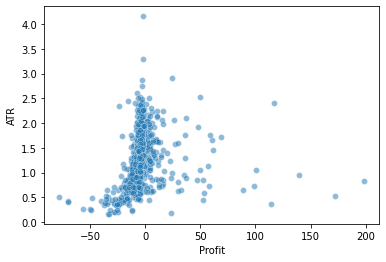

In [69]:
def analysis_one_stock(ticker, 
                       data_pos,
                       data_pos_pivot, # Сводная таблица по позициям каждого тикера
                       stocks_dict_full):
    """ Функция приводит анализ по одной конкретной акции по тикеру. Выводит scatterplot график """
#     pos_tickers = data
    PL_index = data_pos_pivot.index # Тикеры переданных акций
    print('Тикеры открытых позиций', data_pos_pivot.index)
#     for ticker in RL_index:
    stock_quotes = stocks_dict_full_csv[ticker] # Датафрейм котировок акции
    
    one_stock_pos_index = data_pos[data_pos.loc[:, 'Ticker']==ticker].index # Числа, когда были открыты сделки
#### Индексы профитовых и убыточных сделок
    stock_profit_index = data_pos.query("Ticker==@ticker and Profit>0").index
    stock_loss_index = data_pos.query("Ticker==@ticker and Profit<0").index
#### ДФ котировок открытых позиций 
    stock_quotes = stocks_dict_full[ticker] 
    profit_quotes = stocks_dict_full[ticker].loc[stock_profit_index] # Котировки прибыльных
    loss_quotes = stocks_dict_full[ticker].loc[stock_loss_index] # Котировки убыточных
#     display('Котировки прибыльных сделок', profit_quotes)
    
#     one_stock_quotes_pos = stocks_dict_full[ticker].loc[one_stock_pos_index] # Котировки по открытым позициям
    ticker_pos = data_pos[data_pos['Ticker'] == ticker].sort_values(by='Profit', ascending=False) # ДФ открытых сделок
    display(data_pos[data_pos.loc[:,'Ticker'] == ticker].sort_values(ascending=False, by='Profit'))
    
####     ГРАФИКИ
#     atr_f = atr_f.dropna(subset=['N']) # Котировки по акции, кроме первых там где рассчитывается ATR
#     sns.histplot(atr_f['ATR'], bins=100)
    plt.show()
#     sns.scatterplot(y='N', x='ATR', data=profit_quotes, alpha=1) # Рапределение ATR прибыльных сделок (СИНИЕ)
#     sns.scatterplot(y='N', x='ATR', data=loss_quotes, alpha=0.8) #Рапределение ATR убыточных сделок (ЖЕЛТЫЕ)
    sns.scatterplot(y='ATR', x='Profit', data=data_pos, alpha=0.5) #График по открытым сделкам

####    # Корреляция
#     display(data_pos.reset_index(drop=True).style.background_gradient(cmap='coolwarm'))

    
analysis_one_stock('PFE', data_pos_test, data_pos_pivot, stocks_dict_full_csv)